## Imports

In [ ]:
!pip install gensim

In [ ]:
!pip install pyLDAvis

In [ ]:
!pip install datasets

In [ ]:
# Code to make the surprise library work
!pip uninstall -y numpy scikit-surprise tensorflow numba
!pip install numpy==1.26.4
!pip install numba==0.60.0
!pip install scikit-surprise
!pip install tensorflow==2.18.0

In [1]:
import os
import re
import spacy
import html
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import random
import pyLDAvis
import pyLDAvis.gensim
import gensim.downloader

import pickle

from math import sqrt
from datasets import Dataset
from wordcloud import WordCloud
from transformers import pipeline
from tqdm import tqdm

from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler
from transformers import BertTokenizer, BertModel
from datasets import Dataset
from transformers import pipeline

from gensim import corpora, models
from gensim.models import KeyedVectors, LdaModel
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora import Dictionary
from sklearn.cluster import KMeans
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize

from sentence_transformers import SentenceTransformer

from surprise import SVD, Dataset, Reader, accuracy, NMF, KNNBasic
from surprise import KNNWithMeans, KNNBaseline
from surprise.model_selection import GridSearchCV, train_test_split
from collections import defaultdict




## Board Games Data Loading

Firstly, we load the data scraped from the BGG website (https://boardgamegeek.com). This dataset contains the following features: game name, description, year, rating, complexity, minplayers, maxplayers, playingtime, minage and categories

In [ ]:
filename = "boardgames_4122.csv"
games = pd.read_csv(filename, sep=";")
games.head()

id            name                                        description  \
0   1      Die Macher  Die Macher is a game about seven sequential po...   
1   2    Dragonmaster  Dragonmaster is a trick-taking card game based...   
2   3         Samurai  Samurai is set in medieval Japan. Players comp...   
3   4  Tal der Könige  When you see the triangular box and the luxuri...   
4   5         Acquire  In Acquire, each player strategically invests ...   

   year   rating  complexity  minplayers  maxplayers  playingtime  minage  \
0  1986  7.58777      4.3081           3           5          240      14   
1  1981  6.66468      1.9643           3           4           30      12   
2  1998  7.47596      2.4420           2           4           60      10   
3  1992  6.61540      2.6875           2           4           60      12   
4  1964  7.35053      2.4923           2           6           90      12   

                         categories  
0  Economic, Negotiation, Political  
1                Card Game, Fantasy  
2       Abstract Strategy, Medieval  
3                           Ancient  
4      Economic, Territory Building

### Board Games Dataset Exploration

Before preprocessing the descriptions, we will perform a few data exploration steps to understand the dataset

In [ ]:
# Missing Value information
print("Dataset Info:")
print(games.info())
print("\nMissing Values:\n", games.isnull().sum())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4122 entries, 0 to 4121
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           4122 non-null   int64  
 1   name         4122 non-null   object 
 2   description  4122 non-null   object 
 3   year         4122 non-null   int64  
 4   rating       4122 non-null   float64
 5   complexity   4122 non-null   float64
 6   minplayers   4122 non-null   int64  
 7   maxplayers   4122 non-null   int64  
 8   playingtime  4122 non-null   int64  
 9   minage       4122 non-null   int64  
 10  categories   4068 non-null   object 
dtypes: float64(2), int64(6), object(3)
memory usage: 354.4+ KB
None

Missing Values:
 id              0
name            0
description     0
year            0
rating          0
complexity      0
minplayers      0
maxplayers      0
playingtime     0
minage          0
categories     54
dtype: int64


As one can observe, the are only a few NA values. The descriptions feature, which is the important variable for NLP processing, has zero NA values.

Observing the summaries of the numerical features is useful to later apply filtering of games:

In [ ]:
# Summary statistics
print("\nSummary Statistics:")
print(games.describe())


Summary Statistics:
                id         year       rating   complexity   minplayers  \
count  4122.000000  4122.000000  4122.000000  4122.000000  4122.000000   
mean   3211.712033  1958.408782     5.695177     1.717946     2.162300   
std    1733.068617   267.545357     1.337350     1.001928     0.907306   
min       1.000000 -3000.000000     0.000000     0.000000     0.000000   
25%    1791.250000  1981.000000     5.210215     1.063275     2.000000   
50%    3349.500000  1991.000000     5.902780     1.685500     2.000000   
75%    4695.500000  1998.000000     6.500000     2.383900     2.000000   
max    6000.000000  2012.000000     9.500000     5.000000    10.000000   

        maxplayers   playingtime       minage  
count  4122.000000   4122.000000  4122.000000  
mean      5.581029    113.636827     9.092431  
std      10.144807    985.820912     3.885081  
min       0.000000      0.000000     0.000000  
25%       2.000000     30.000000     8.000000  
50%       4.000000     6

Now we will observe the categories count to see what are the most common ones:

In [ ]:
# Categorical overview
print("\nUnique Categories Count:")
print(games['categories'].nunique())

print("\nMost Common Categories:")
print(games['categories'].value_counts().head(10))


Unique Categories Count:
1704

Most Common Categories:
categories
Abstract Strategy              229
Card Game                      200
Wargame, World War II          145
Economic                        79
Science Fiction, Wargame        53
Sports                          47
Dice                            45
Deduction, Murder / Mystery     43
Word Game                       35
Modern Warfare, Wargame         33
Name: count, dtype: int64


Most of the games inside the dataset are either card games or abstract strategy.

Let's now observe the distributions of the numerical variables

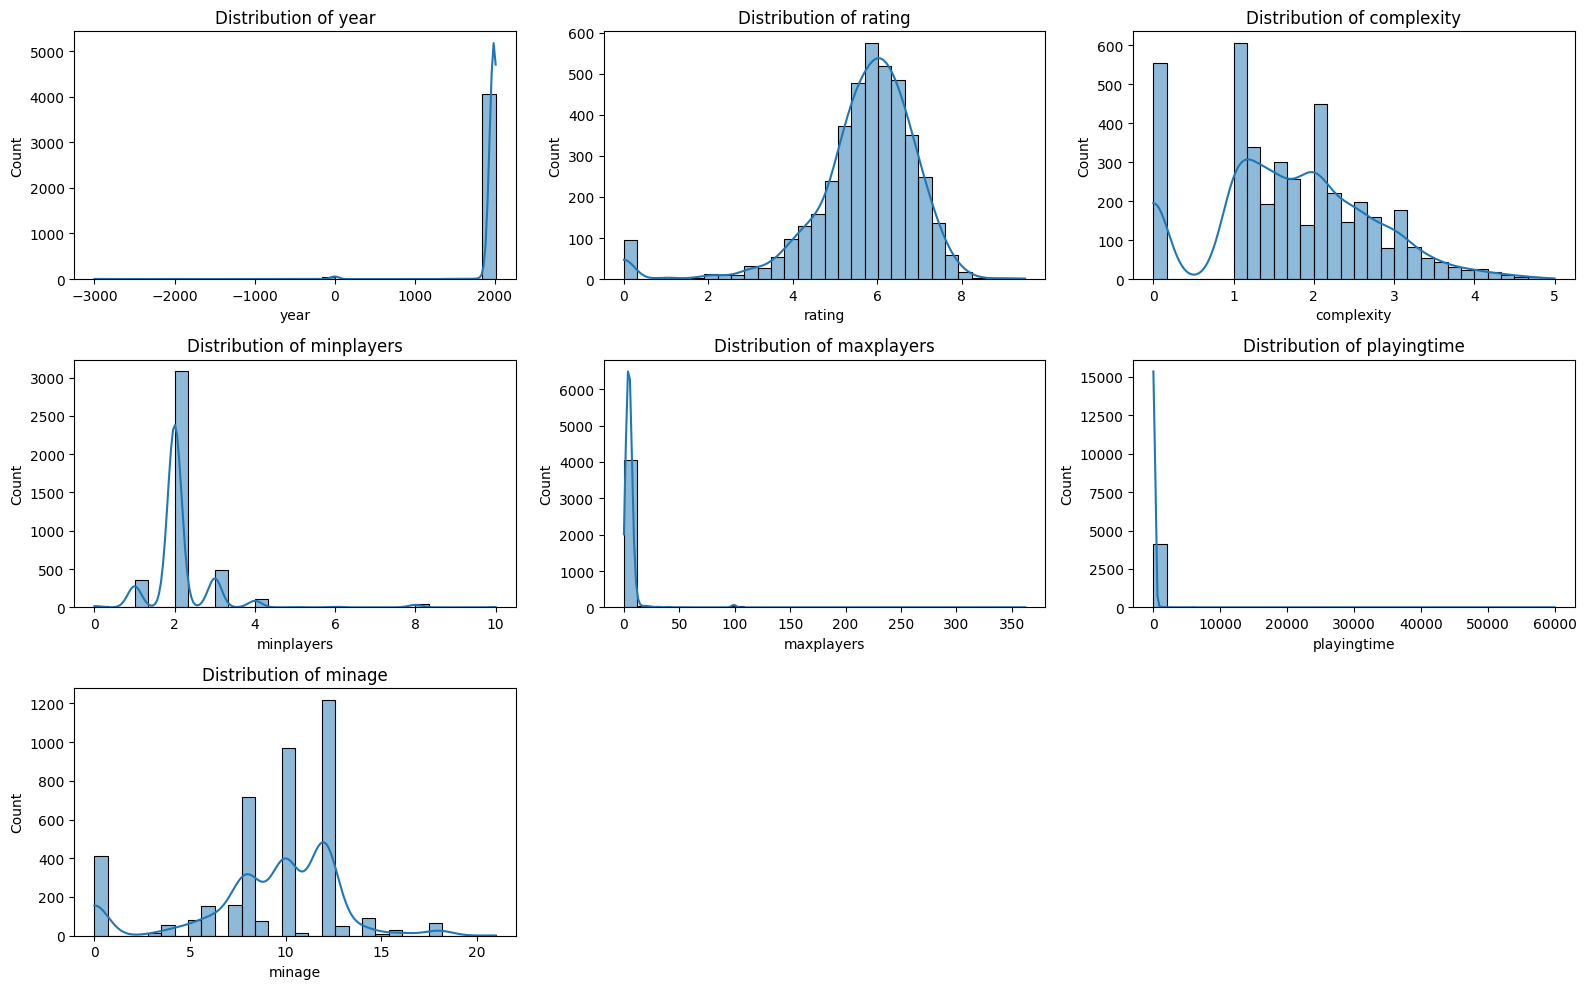

In [ ]:
# Distribution plots
numeric_features = ['year', 'rating', 'complexity', 'minplayers', 'maxplayers', 'playingtime', 'minage']

plt.figure(figsize=(16, 10))
for i, feature in enumerate(numeric_features):
    plt.subplot(3, 3, i+1)
    sns.histplot(games[feature].dropna(), kde=True, bins=30)
    plt.title(f"Distribution of {feature}")
plt.tight_layout()
plt.show()

We can see that the mean rating of the games is around 6, and that most of the games are recent. However, there are some outlier games whose year of creation is before Christ, these are the following:

In [ ]:
# Filter games year of creation below 0
invalid_year_games = games[games['year'] < 0]

# Display the results
print("Games with year < 0:")
print(invalid_year_games[['id', 'name', 'year']])

Games with year < 0:
        id                                      name  year
129    188                                        Go -2200
924   1602                      The Royal Game of Ur -2600
1734  2912  Hounds and Jackals: Game of the Pharaohs -2000
2464  3886                         Nine Men's Morris -1400
2694  4148                                     Mehen -3000
3658  5432                        Chutes and Ladders  -200
3755  5546                                   Marbles -3000


These games are mostly from Egypt

Let's observe the correlation between variables.

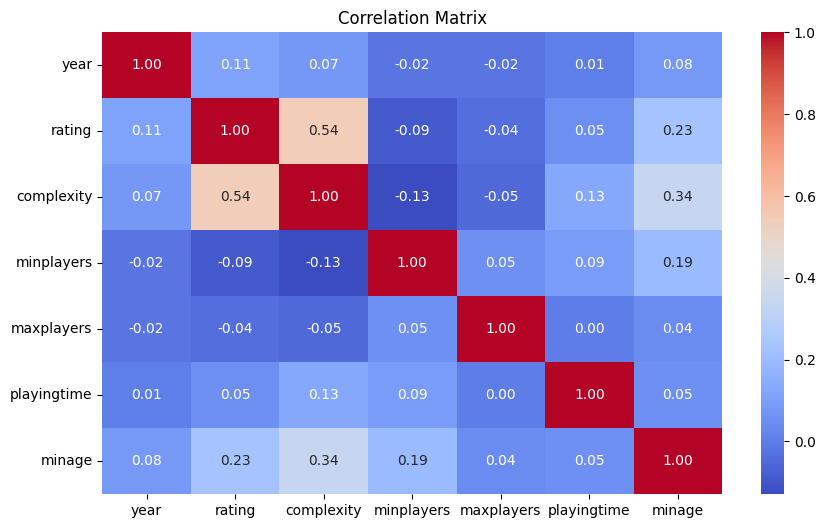

In [ ]:
# Correlation heatmap
plt.figure(figsize=(10, 6))
corr_matrix = games[numeric_features].corr()
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

We can observe that most of them are uncorrelated. The only variables that are quite positively correlated are complexity with rating, which makes sense.

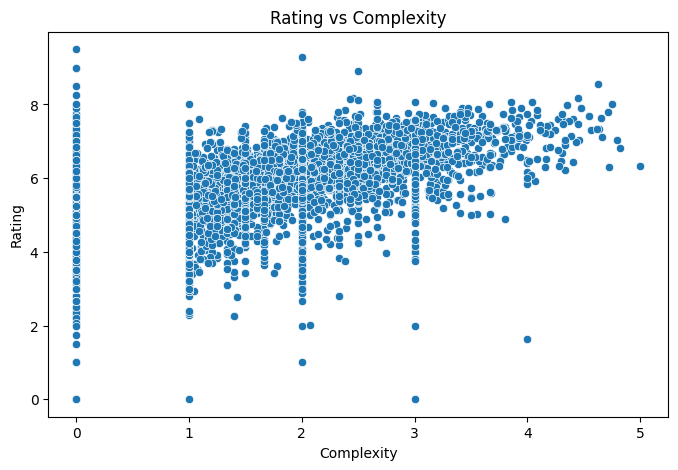

In [ ]:
# Boxplot of rating vs complexity
plt.figure(figsize=(8, 5))
sns.scatterplot(x='complexity', y='rating', data=games)
plt.title("Rating vs Complexity")
plt.xlabel("Complexity")
plt.ylabel("Rating")
plt.show()

Let's explore the length of the descriptions.

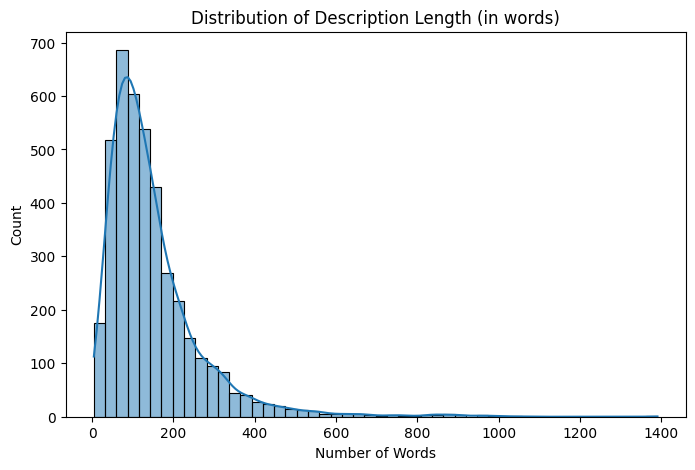

In [ ]:
# Description length analysis
games['description_length'] = games['description'].apply(lambda x: len(str(x).split()))
plt.figure(figsize=(8, 5))
sns.histplot(games['description_length'], bins=50, kde=True)
plt.title("Distribution of Description Length (in words)")
plt.xlabel("Number of Words")
plt.ylabel("Count")
plt.show()

Most of the descriptions contain more than 100 words. The mean is 160. This means that the descriptions are very complete and explain fully the board games.


## Task 1: Text Preprocessing and vectorization

### Text Preprocessing

To implement the NLP preprocessing pipeline, we used the Spacy library, with a pretrained model 'en_core_web_sm'.

We define manually some custom stopwords that are common to all games and do not have relevance.

In [ ]:
# Load English spaCy model
nlp = spacy.load("en_core_web_sm")

custom_stopwords = {
    "game", "s", "t", "play", 'player', 'move', 'turn', 'win', 'lose', 'score', 'value',
    'collect', 'lose', 'victory', 'try', 'use', 'end', 'set', 'allow',
    'number', 'total', 'get', 'include', 'rule', 'content'
}

def clean_text(text):
    if pd.isna(text):
        return ""

    # Lowercase
    text = text.lower()

    # Remove HTML tags
    text = re.sub(r"<.*?>", " ", text)

    # Remove special characters and numbers
    text = re.sub(r"[^a-z\s]", " ", text)

    # Remove extra whitespace
    text = re.sub(r"\s+", " ", text).strip()

    # Apply spaCy NLP processing
    doc = nlp(text)

    # Remove stopwords, lemmatize, exclude punctuations, and custom words
    tokens = [
        token.lemma_ for token in doc
        if not token.is_stop and token.is_alpha and token.lemma_ not in custom_stopwords
    ]

    return " ".join(tokens)

In [ ]:
# Apply the cleaning function to all descriptions
games["clean_description"] = games["description"].apply(clean_text)

In [ ]:
# Example: original and cleaned text for first entry
print("Original:\n", games["description"][0])
print("Cleaned:\n", games["clean_description"][0])

Original:
 Die Macher is a game about seven sequential political races in different regions of Germany. Players are in charge of national political parties, and must manage limited resources to help their party to victory. The winning party will have the most victory points after all the regional elections. There are four different ways of scoring victory points. First, each regional election can supply one to eighty victory points, depending on the size of the region and how well your party does in it. Second, if a party wins a regional election and has some media influence in the region, then the party will receive some media-control victory points. Third, each party has a national party membership which will grow as the game progresses and this will supply a fair number of victory points. Lastly, parties score some victory points if their party platform matches the national opinions at the end of the game.&#10;&#10;The 1986 edition featured four parties from the old West Germany and

Now the most common words will be explored. This way we can tune the custom stopwords by adding tokens that are not relevant or that are common for all games and do not add any information as a whole.

In [ ]:
# Combine all cleaned descriptions
all_cleaned_text = ' '.join(games['clean_description'].dropna())

# Tokenize the cleaned text
clean_tokens = all_cleaned_text.split()

# Count word frequencies
clean_word_counts = Counter(clean_tokens)

# Get the 30 most common words
most_common_clean_words = clean_word_counts.most_common(30)

print("Most common words in cleaned descriptions:")
for word, count in most_common_clean_words:
    print(f"{word}: {count}")

Most common words in cleaned descriptions:
card: 6914
quot: 5943
board: 2228
point: 1877
piece: 1476
place: 1295
time: 1131
dice: 1088
space: 1082
war: 1058
battle: 1027
roll: 1022
new: 994
color: 943
tile: 925
different: 874
unit: 868
opponent: 865
hand: 844
map: 811
start: 794
counter: 791
base: 776
combat: 759
round: 742
die: 727
edition: 725
high: 690
control: 684
world: 669


Save clean dataset (if desired)

In [ ]:
games.to_csv("boardgames_4122_clean.csv", index=False, encoding="utf-8", sep=";")

### Vectorization

#### BoW and TF-IDF

The first two vectorization techniques applied are BoW and TF-IDF. The BoW model represents each of the documents as a sparse vector of word counts. On the other hand,  TF-IDF is the refinement of BoW, which is done by giving a weight to the words based on their term frequency. Words that are very common will be given a small weight, whereas the rare and distinctive words are bound to have a higher weight.

In [ ]:
# For this task, we will mainly be working with the column "clean_description".
# We will tokenize this part fist
tokenized_descr = [clean_description.split() for clean_description in games["clean_description"]]

In [ ]:
# Then we will create a dictionary and obtain both the BoW corpus and the TF-IDF corpus
# BoW corpus
dictionary = corpora.Dictionary(tokenized_descr)
bow_corpus = [dictionary.doc2bow(doc) for doc in tokenized_descr]

# TF-IDF corpus
tfidf = models.TfidfModel(bow_corpus)
tfidf_corpus = tfidf[bow_corpus]

Now we would like to obtain some insights from our data using the TF-IDF corpus. However, we cannot use it as it is. `tfidf_corpus`is a sparse corpus matrix, not a dense numpy matrix.

Gensim is optimized for streaming large corpora and if we wanted to do some visualizations, we would need to convert it to dense form.

In [ ]:
num_docs = len(tfidf_corpus)
num_terms = len(dictionary)

# Create empty matrix
X_tfidf_gensim = np.zeros((num_docs, num_terms))

# Fill it with TF-IDF scores
for doc_idx, doc in enumerate(tfidf_corpus):
    for term_id, tfidf_score in doc:
        X_tfidf_gensim[doc_idx, term_id] = tfidf_score

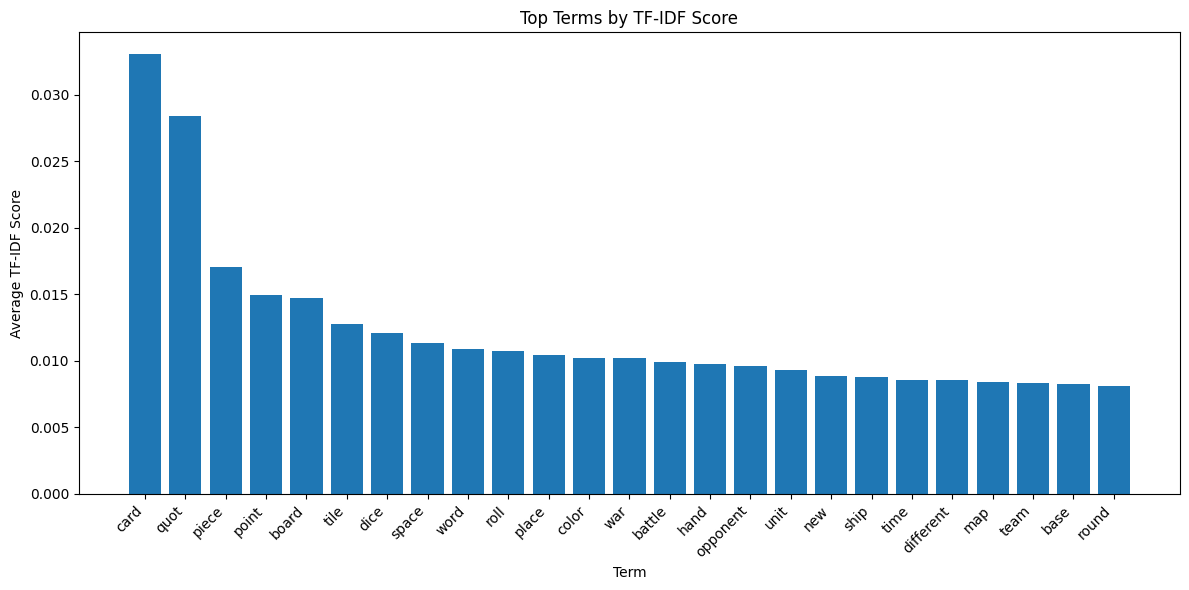

In [ ]:
# Compute average TF-IDF per term
avg_tfidf_scores = X_tfidf_gensim.mean(axis=0)

# Top-N terms
top_n = 25
top_term_indices = avg_tfidf_scores.argsort()[::-1][:top_n]

# Get corresponding terms
terms = [dictionary[i] for i in top_term_indices]

# Plot
plt.figure(figsize=(12, 6))
plt.bar(range(top_n), avg_tfidf_scores[top_term_indices], tick_label=terms)
plt.xlabel('Term')
plt.ylabel('Average TF-IDF Score')
plt.title('Top Terms by TF-IDF Score')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

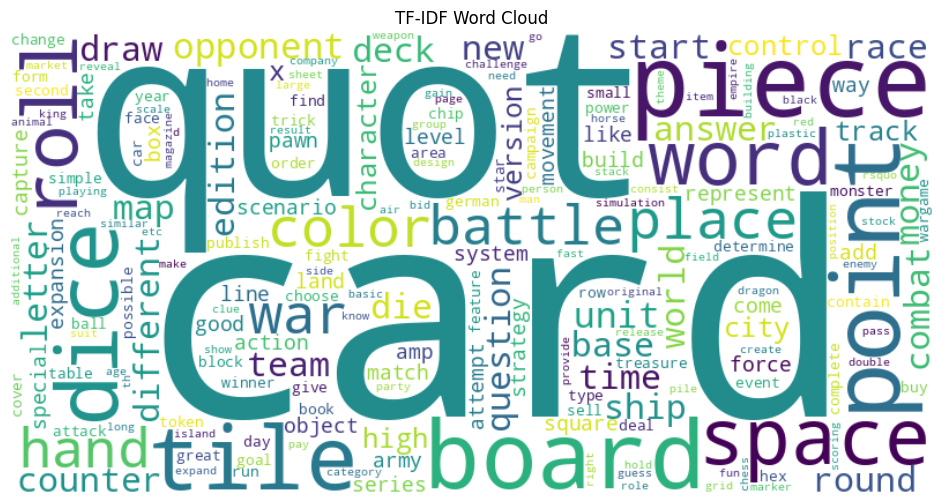

In [ ]:
# Total TF-IDF score per term across all documents
tfidf_term_scores = X_tfidf_gensim.sum(axis=0)

# Map term to score
word_freq = {dictionary[i]: tfidf_term_scores[i] for i in range(num_terms)}

# Generate word cloud
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    colormap='viridis',
    max_words=200
).generate_from_frequencies(word_freq)

# Display
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('TF-IDF Word Cloud')
plt.show()

As observed in both the top words histogram and the word cloud, most of the high ranked words are highly related to board games. However, words that are common appear with a high ranking, such as card, piece, point. Those words are relevant because not all games strictly have them but they are common, which means that they should not have such high score.

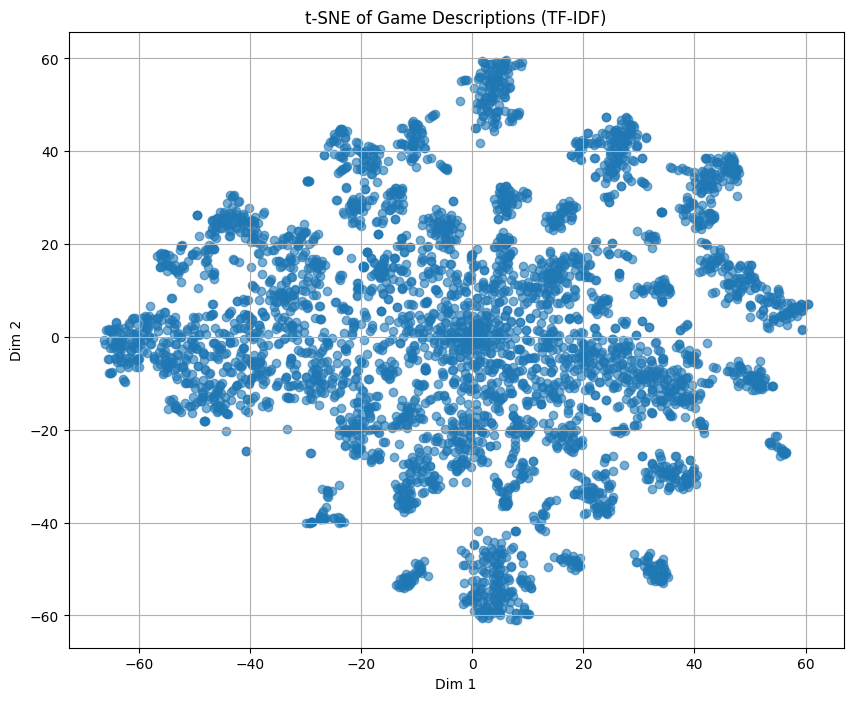

In [ ]:
# Dimensionality reduction
X_reduced = PCA(n_components=50).fit_transform(X_tfidf_gensim)
X_embedded = TSNE(n_components=2, perplexity=30, random_state=42).fit_transform(X_reduced)

# Plot
plt.figure(figsize=(10, 8))
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], alpha=0.6)
plt.title("t-SNE of Game Descriptions (TF-IDF)")
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.grid(True)
plt.show()

We can observe most of the games clustered in the center of the graph, which means that most games have similar descriptions. Hoewever, some tiny clusters can be observed in the surroundings, which can represent similar games in theme or rules.

#### GloVe Embeddings

GloVe is an unsupervised learning algorithm used to obtain word embeddings by factorizing a word co-occurrence matrix. This embedding approach captures semantic relationships between words by co-occurrence, which means how often the words appear together. We have implemented 2 pretrained model, the one with dimension 100 and another with dimension 300. However, due to the complexity of the descriptions, we decided to use dimension 300 to have a bigger representation and capture better semantic meaning.


In [ ]:
def load_glove_embeddings(filepath="glove.6B.300d.txt"):
    embeddings = {}
    with open(filepath, "r", encoding="utf8") as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            embeddings[word] = vector
    return embeddings

def get_glove_vector(text, glove, dim=300):
    words = text.split()
    vectors = [glove[word] for word in words if word in glove]
    return np.mean(vectors, axis=0) if vectors else np.zeros(dim)

# Load the 100-dimensional GloVe embeddings
glove = load_glove_embeddings("glove.6B.100d.txt")

# Apply GloVe embeddings to each game's description
games["glove_vector100"] = games["clean_description"].apply(lambda x: get_glove_vector(x, glove, dim=100))

# Load the 300-dimensional GloVe embeddings
glove = load_glove_embeddings("glove.6B.300d.txt")

# Apply GloVe embeddings to each game's description
games["glove_vector"] = games["clean_description"].apply(lambda x: get_glove_vector(x, glove, dim=300))

print(games["glove_vector"].head())

0    [-0.09439622, 0.073867284, 0.024768665, -0.214...
1    [-0.06504974, 0.18026842, -0.0912874, -0.06168...
2    [-0.083981246, 0.013731034, 0.07079916, -0.191...
3    [-0.17044395, 0.08557909, -0.1520173, -0.21974...
4    [-0.091748945, 0.028520625, -0.0751958, -0.140...
Name: glove_vector, dtype: object


In [ ]:
len(games["glove_vector100"][0]), len(games["glove_vector"][0])

(100, 300)

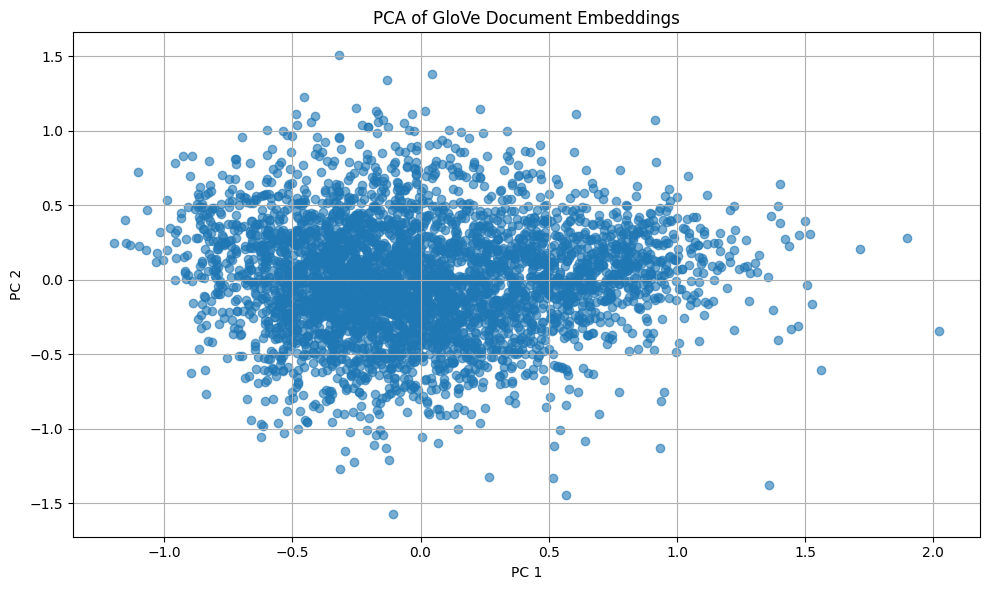

Explained Variance (first 2 components): 21.10%


In [ ]:
# Reduce GloVe (100ver) to 2D with PCA
pca = PCA(n_components=2)
X_glove100 = np.vstack(games["glove_vector100"].values)
X_glove_pca100 = pca.fit_transform(X_glove100)

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(X_glove_pca100[:, 0], X_glove_pca100[:, 1], alpha=0.6)
plt.title("PCA of GloVe Document Embeddings")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.grid(True)
plt.tight_layout()
plt.show()

# How much variance PCA retained
explained_var = pca.explained_variance_ratio_.sum()
print(f"Explained Variance (first 2 components): {explained_var:.2%}")

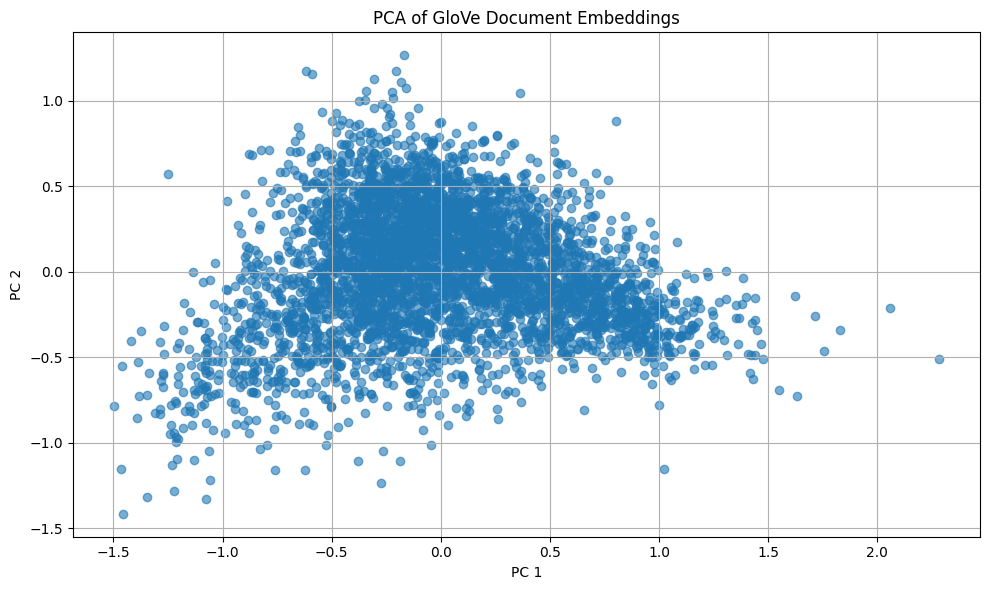

Explained Variance (first 2 components): 16.53%


In [ ]:
# Reduce GloVe (300ver) to 2D with PCA
pca = PCA(n_components=2)
X_glove = np.vstack(games["glove_vector"].values)
X_glove_pca = pca.fit_transform(X_glove)

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(X_glove_pca[:, 0], X_glove_pca[:, 1], alpha=0.6)
plt.title("PCA of GloVe Document Embeddings")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.grid(True)
plt.tight_layout()
plt.show()

# How much variance PCA retained
explained_var = pca.explained_variance_ratio_.sum()
print(f"Explained Variance (first 2 components): {explained_var:.2%}")

The previous plot represents that the embeddings of the descriptions are quite similar, because they are close together. No clear clusters can be identified in the embeddings

#### Doc2Vec Embeddings

Doc2Vec is actually an extension of Word2Vec, which also generates word embeddings. It is designed to generate vector representations of whole documents or sentences.

Opposite to Word2Vec, which is implemented to learn embeddings for individual words, Doc2Vec assigns a unique vector to each document apart from learning word embeddings. The model then captures semantic meaning at the document level by training on both contexts, word and document.



In [ ]:
# Prepare data
documents = [TaggedDocument(words=text.split(), tags=[str(i)]) for i, text in enumerate(games["clean_description"])]

# Train
doc2vec_model = Doc2Vec(documents, vector_size=300, window=5, min_count=2, workers=4, epochs=40)

# Vectorize
X_doc2vec = np.array([doc2vec_model.dv[str(i)] for i in range(len(documents))])

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


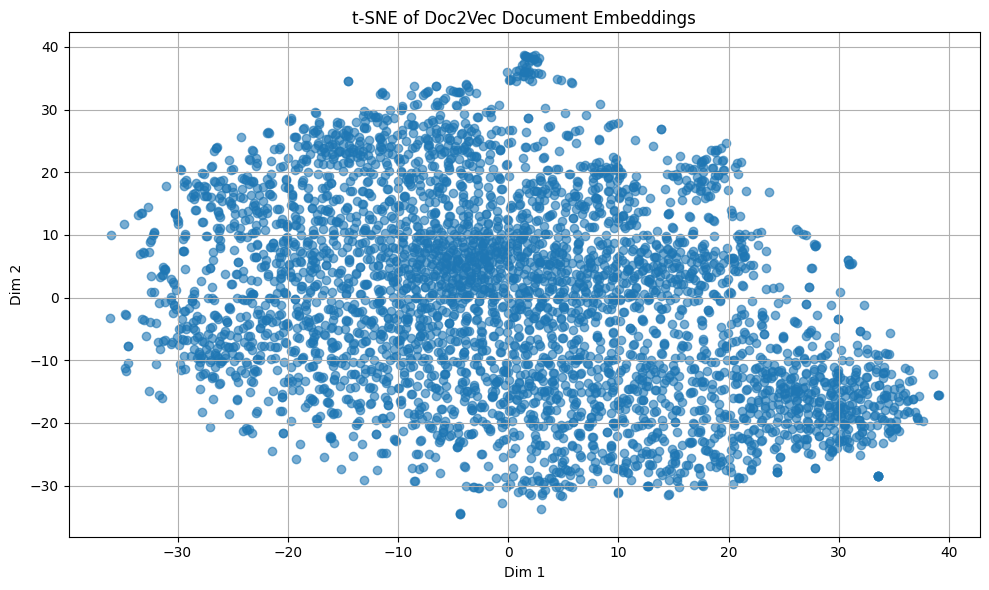

In [ ]:
# Run t-SNE on doc2vec vectors
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, n_iter=1000, random_state=42)
X_doc2vec_tsne = tsne.fit_transform(X_doc2vec)

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(X_doc2vec_tsne[:, 0], X_doc2vec_tsne[:, 1], alpha=0.6)
plt.title("t-SNE of Doc2Vec Document Embeddings")
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.grid(True)
plt.tight_layout()
plt.show()

A similar conclusion can be drawn from this second approach, no clusters are observed and most of the points are close together. However, we can observe a bit more of separation between embeddings and some mixtures of distributions could be spotted

#### Similar Games' Comparison

In [ ]:
def find_similar_glove_df(target_game, df, vector_column="glove_vector", name_column="name", top_k=5):
    # Get the target row
    target_row = df[df[name_column] == target_game]
    if target_row.empty:
        print(f"Game '{target_game}' not found.")
        return

    target_vec = np.array(target_row.iloc[0][vector_column]).reshape(1, -1)

    similarities = []

    for _, row in df.iterrows():
        other_name = row[name_column]
        if other_name == target_game:
            continue
        other_vec = np.array(row[vector_column]).reshape(1, -1)
        sim = cosine_similarity(target_vec, other_vec)[0][0]
        similarities.append((other_name, sim))

    sorted_games = sorted(similarities, key=lambda x: -x[1])
    for game, sim in sorted_games[:top_k]:
        print(f"{game} (distance={1 - sim:.4f})")

find_similar_glove_df("CATAN", games, top_k=5)

CATAN: Cities & Knights (distance=0.0512)
Targui (distance=0.0776)
Magna Grecia (distance=0.0777)
Space Race (distance=0.0889)
Clippers (distance=0.0913)


In [ ]:
def find_similar_doc2vec_df(target_game, df, model, name_column="name", top_k=5, return_results=False):
    target_idx = df[df[name_column] == target_game].index
    if target_idx.empty:
        print(f"Game '{target_game}' not found.")
        return

    target_idx = target_idx[0]
    target_vec = model.dv[target_idx].reshape(1, -1)

    similarities = []
    for idx, row in df.iterrows():
        if idx == target_idx:
            continue
        other_vec = model.dv[idx].reshape(1, -1)
        sim = cosine_similarity(target_vec, other_vec)[0][0]
        distance = 1 - sim
        similarities.append((row[name_column], distance))

    # Sort by increasing distance
    sorted_games = sorted(similarities, key=lambda x: x[1])

    print(f"\nSimilar games to '{target_game}' using Doc2Vec:")
    for game, dist in sorted_games[:top_k]:
        print(f"{game} (distance={dist:.4f})")

    if return_results:
        return sorted_games[:top_k]

find_similar_doc2vec_df("CATAN", games, doc2vec_model, top_k=5)


Similar games to 'CATAN' using Doc2Vec:
CATAN: Cities & Knights (distance=0.3475)
Die Magier von Pangea (distance=0.3503)
New England (distance=0.3617)
Magna Grecia (distance=0.4163)
Carcassonne: Hunters and Gatherers (distance=0.4171)


#### LDA

Latent Dirichlet Allocation (LDA) is a generative probabilistic model which is used for topic modeling and discovering abstract topics within the collection of documents presented, the descriptions of the games.

In [ ]:
corpus = games['clean_description'].tolist()

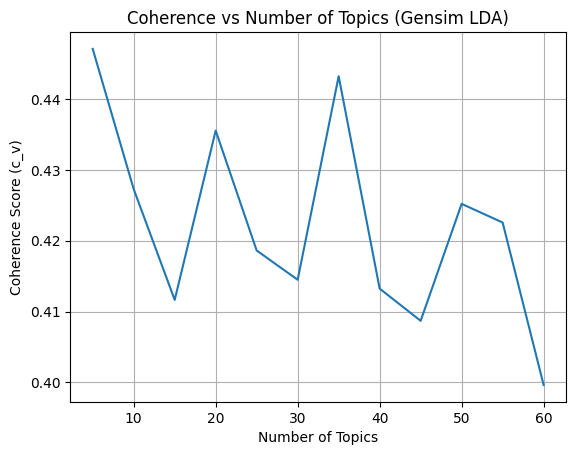

In [ ]:
# Try different numbers of topics
coherence_scores = []
models = []
for k in range(5, 61, 5):
    model = LdaModel(corpus=bow_corpus, id2word=dictionary, num_topics=k, passes=15, random_state=42)
    coherence = CoherenceModel(model=model, texts=tokenized_descr, dictionary=dictionary, coherence='c_v').get_coherence()
    coherence_scores.append(coherence)
    models.append(model)

# Plot coherence vs. topic count
plt.plot(range(5, 61, 5), coherence_scores)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score (c_v)")
plt.title("Coherence vs Number of Topics (Gensim LDA)")
plt.grid(True)
plt.show()

# Select best model
best_k = range(5, 61, 5)[np.argmax(coherence_scores)]
best_model = models[np.argmax(coherence_scores)]
best_model.save("lda_best_model.gensim")

In [ ]:
for topic_id, words in best_model.show_topics(num_topics=best_k, num_words=10, formatted=False):
    print(f"Topic {topic_id}: {[word for word, prob in words]}")

Topic 0: ['board', 'piece', 'quot', 'dice', 'space', 'roll', 'opponent', 'square', 'color', 'place']
Topic 1: ['island', 'sell', 'buy', 'land', 'different', 'card', 'board', 'market', 'gameboard', 'swimmer']
Topic 2: ['quot', 'word', 'question', 'letter', 'card', 'answer', 'category', 'box', 'version', 'team']
Topic 3: ['quot', 'unit', 'war', 'battle', 'counter', 'scenario', 'point', 'map', 'combat', 'level']
Topic 4: ['card', 'quot', 'hand', 'point', 'round', 'deck', 'tile', 'draw', 'color', 'start']


The beta vector represents the weight of the important words in each topic.

In [ ]:
beta_matrix = np.array(best_model.get_topics())
print("Beta shape:", beta_matrix.shape)

Beta shape: (5, 19726)


In [ ]:
words = [dictionary[i] for i in range(len(dictionary))]

# We create a dataframe to read the results better
beta_df = pd.DataFrame(beta_matrix, columns=words, index=[f"Topic {i}" for i in range(best_k)])

# Here we display the top words per topic (beta vectors), with the probabilities.
for topic_id in range(best_k):
    print(f"\nTopic {topic_id}:")
    print(beta_df.iloc[topic_id].sort_values(ascending=False).head(10))


Topic 0:
board       0.017151
piece       0.013515
quot        0.013045
dice        0.011171
space       0.007110
roll        0.006987
opponent    0.005868
square      0.005805
color       0.005721
place       0.005617
Name: Topic 0, dtype: float32

Topic 1:
island       0.008787
sell         0.008604
buy          0.007261
land         0.005891
different    0.005631
card         0.005629
board        0.005444
market       0.005133
gameboard    0.004721
swimmer      0.004604
Name: Topic 1, dtype: float32

Topic 2:
quot        0.034033
word        0.017694
question    0.012738
letter      0.010901
card        0.009209
answer      0.008439
category    0.006377
box         0.006349
version     0.005512
team        0.005193
Name: Topic 2, dtype: float32

Topic 3:
quot        0.025950
unit        0.015254
war         0.014844
battle      0.013626
counter     0.011431
scenario    0.010985
point       0.010620
map         0.010437
combat      0.009387
level       0.008698
Name: Topic 3, dtype

In a more compact way:

In [ ]:
best_model.show_topics(num_topics=-1, num_words=10, log=False, formatted=True)

[(0,
  '0.017*"board" + 0.014*"piece" + 0.013*"quot" + 0.011*"dice" + 0.007*"space" + 0.007*"roll" + 0.006*"opponent" + 0.006*"square" + 0.006*"color" + 0.006*"place"'),
 (1,
  '0.009*"island" + 0.009*"sell" + 0.007*"buy" + 0.006*"land" + 0.006*"different" + 0.006*"card" + 0.005*"board" + 0.005*"market" + 0.005*"gameboard" + 0.005*"swimmer"'),
 (2,
  '0.034*"quot" + 0.018*"word" + 0.013*"question" + 0.011*"letter" + 0.009*"card" + 0.008*"answer" + 0.006*"category" + 0.006*"box" + 0.006*"version" + 0.005*"team"'),
 (3,
  '0.026*"quot" + 0.015*"unit" + 0.015*"war" + 0.014*"battle" + 0.011*"counter" + 0.011*"scenario" + 0.011*"point" + 0.010*"map" + 0.009*"combat" + 0.009*"level"'),
 (4,
  '0.075*"card" + 0.025*"quot" + 0.012*"hand" + 0.009*"point" + 0.008*"round" + 0.008*"deck" + 0.008*"tile" + 0.007*"draw" + 0.007*"color" + 0.007*"start"')]

The theta vectors explain how much of each topic is inside the documents. Note that only the few first topics are relevant, the ones with high weights. Therefore, to avoid computational cost, we opt to take only the most relevant topic.

In [ ]:
theta_matrix = []
for doc in bow_corpus:
    doc_topics = best_model.get_document_topics(doc, minimum_probability=0)
    theta_matrix.append([prob for _, prob in doc_topics])

theta_matrix = np.array(theta_matrix)
print("Theta shape:", theta_matrix.shape)

Theta shape: (4122, 5)


In [ ]:
# Dataframe for the thetas
theta_df = pd.DataFrame(theta_matrix, columns=[f"Topic {i}" for i in range(best_k)])

# We just display the most relevant topic (the one with the highest probability)
theta_df["Dominant Topic"] = theta_df.idxmax(axis=1)

print(theta_df[["Dominant Topic"]])

     Dominant Topic
0           Topic 2
1           Topic 4
2           Topic 0
3           Topic 0
4           Topic 0
...             ...
4117        Topic 3
4118        Topic 3
4119        Topic 3
4120        Topic 3
4121        Topic 3

[4122 rows x 1 columns]


A very interactive repesentation of the topics can be observed using the pyLDAvis library. Here we can see the diferent topics in a two dimensional graph, showing their relevance across the documents and the words inside them.

In [ ]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(best_model, bow_corpus, dictionary)
pyLDAvis.save_html(vis, "assets/lda_vis.html")
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.017933  0.053739       1        1  33.678682
4     -0.052125  0.110886       2        1  24.583048
3      0.262878 -0.113636       3        1  20.059372
2     -0.027883  0.141396       4        1  15.192638
1     -0.200803 -0.192384       5        1   6.486260, topic_info=         Term         Freq        Total Category  logprob  loglift
56       card  5999.000000  5999.000000  Default  30.0000  30.0000
82       quot  5929.000000  5929.000000  Default  29.0000  29.0000
1319     word   763.000000   763.000000  Default  28.0000  28.0000
367      unit   868.000000   868.000000  Default  27.0000  27.0000
349       war   847.000000   847.000000  Default  26.0000  26.0000
...       ...          ...          ...      ...      ...      ...
56       card   103.569070  5999.516045   Topic5  -5.1798  -1.3237
344      roll    78.487031  1162.522040   Topic5  -5.4571   0.0401
0         add    63.873859   478.210593   Topic5  -5.6632   0.7223
133      ship    62.622182   521.779092   Topic5  -5.6829   0.6154
12    feature    56.362749   365.273437   Topic5  -5.7883   0.8666

[366 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
2393      5  0.958336      aboard
1380      1  0.925705    abstract
1380      3  0.072934    abstract
433       1  0.997716  accomplish
653       1  0.658383      action
...     ...       ...         ...
327       4  0.333253       world
327       5  0.066651       world
970       1  0.416022           x
970       2  0.107676           x
970       3  0.474754           x

[664 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 5, 4, 3, 2])

The most relevant topic is 1, since it is the one most documents have as the most coherent.

The topics can be interpreted as:

Topic 0: Games centered around movement and positioning on a board (dice, pieces, squares, colors…).

Topic 1: Resource trading and island exploration (island, buy, sell, market…).

Topic 2: Trivia games (word, letter, question, answer, category…).

Topic 3: War or combat simulation games (unit, battle, map, scenario, combat…).

Topic 4: Card-based games (card, deck, hand, draw, tile…).


 ## Sentiment Analysis

In this case, we will be using a zero-shot model from Facebook. We need to be careful when using these models because:

*   They are trained on natural language, not preprocessed or lemmatized text.
*   They expect raw sentences to understand semantic tone.
*   They perform better when given more expressive and emotional content, which can get lost when lemmatizing everything.

Because of this, we need to preprocess again the game descriptions with light preprocessing and use that for using the model that we have selected.

There is an important aspect to consider here, which is that zero-shot classification with large transformer models is computationally expensive and slow when done sequentially.

To optimize performance, we convert our data to a Hugging Face Dataset object, which allows us to apply classification in efficient batches. Batching not only reduces runtime significantly, but also allows the model to process multiple descriptions in parallel without affecting the accuracy of individual predictions.

As a result of the classification process, we introduced two new variables into our dataset: `predicted_emotion` and `predicted_vibe`. The former reflects the emotional or narrative mood of the game (e.g., dark, funny, nostalgic), while the latter characterizes the gameplay dynamics or player experience (e.g., strategic, cooperative, family-friendly).

In [ ]:
def light_clean(text):
    if pd.isna(text):
        return ""
    text = re.sub(r"<.*?>", " ", text)       # remove HTML
    text = re.sub(r"\s+", " ", text).strip() # normalize whitespace
    return text

In [ ]:
# Load your clean dataframe
games["light_clean_description"] = games["description"].apply(light_clean)
hf_dataset = Dataset.from_pandas(games[["light_clean_description"]])

# Load the zero-shot classifier
classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli", device=0)  # device=0 to use GPU

# Labels
emotional_labels = ["funny", "dark", "happy", "serious", "nostalgic", "intense"]
vibe_labels = ["strategic", "cooperative", "competitive", "family-friendly", "chaotic", "educational"]

# Batched classification function
def classify_batch(batch):
    texts = batch["light_clean_description"]

    # Predict emotions and vibes together
    emotion_results = classifier(texts, emotional_labels, batch_size=8)
    vibe_results = classifier(texts, vibe_labels, batch_size=8)

    # If input is batched, results will be a list of dicts
    predicted_emotion = [result["labels"][0] for result in emotion_results]
    predicted_vibe = [result["labels"][0] for result in vibe_results]

    return {
        "predicted_emotion": predicted_emotion,
        "predicted_vibe": predicted_vibe
    }

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Device set to use cuda:0


In [ ]:
# Apply with batching
hf_dataset = hf_dataset.map(classify_batch, batched=True, batch_size=8)

# Convert back to pandas
games["predicted_emotion"] = hf_dataset["predicted_emotion"]
games["predicted_vibe"] = hf_dataset["predicted_vibe"]

Map:   0%|          | 0/4122 [00:00<?, ? examples/s]

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


In [ ]:
games.drop(columns=['light_clean_description'], inplace=True)

In [ ]:
games.to_csv("boardgames_4122_clean_glove_dual_tone.csv", sep=";", index=False)

In [ ]:
num_examples = 100

for i in range(num_examples):
    name = games.iloc[i]["name"]
    description = games.iloc[i]["description"][:500]
    emotion = games.iloc[i]["predicted_emotion"]
    vibe = games.iloc[i]["predicted_vibe"]

    print(f"Game: {name}")
    print(f"Description:\n{description}...")
    print(f"Predicted Emotion: {emotion}")
    print(f"Predicted Vibe: {vibe}\n")

Game: Die Macher
Description:
Die Macher is a game about seven sequential political races in different regions of Germany. Players are in charge of national political parties, and must manage limited resources to help their party to victory. The winning party will have the most victory points after all the regional elections. There are four different ways of scoring victory points. First, each regional election can supply one to eighty victory points, depending on the size of the region and how well your party does in it. Se...
Predicted Emotion: intense
Predicted Vibe: competitive

Game: Dragonmaster
Description:
Dragonmaster is a trick-taking card game based on an older game called Coup d'&#195;&#137;tat. Each player is given a supply of plastic gems, which represent points. Each player will get to be the dealer for five different hands, with slightly different goals for each hand. After all cards have been dealt out, the dealer decides which hand best suits his or her current cards,

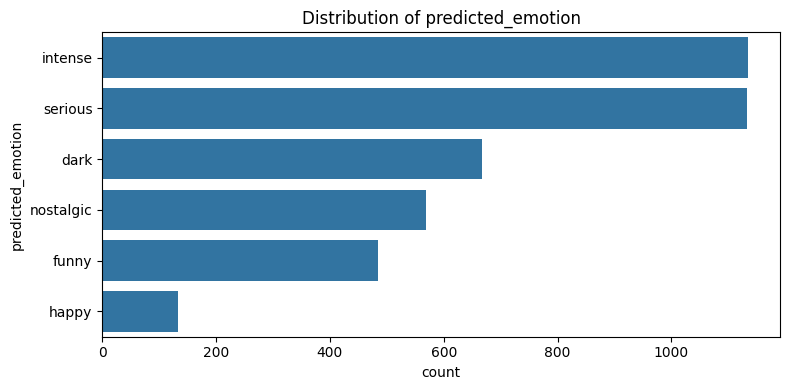

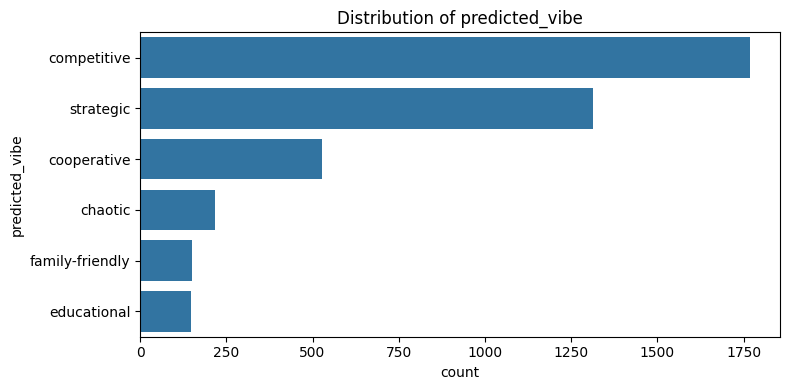

In [ ]:
for col in ["predicted_emotion", "predicted_vibe"]:
    plt.figure(figsize=(8, 4))
    sns.countplot(data=games, y=col, order=games[col].value_counts().index)
    plt.title(f"Distribution of {col}")
    plt.tight_layout()
    plt.show()

## Task 2: Machine Learning (Recommender System)

#### Load dataset and reviews

Loading again the games dataset with all the processes included in Task 1.

In [2]:
filename = "boardgames_4122_clean_glove_dual_tone.csv"
games = pd.read_csv(filename, sep=";")
games

id                                               name  \
0        1                                         Die Macher   
1        2                                       Dragonmaster   
2        3                                            Samurai   
3        4                                     Tal der Könige   
4        5                                            Acquire   
...    ...                                                ...   
4117  5996  The Battle for Cassino: Assaulting the Gustav ...   
4118  5997              Pleasant Hill: The Red River Campaign   
4119  5998                       The Italian Campaign: Sicily   
4120  5999                      The Italian Campaign: Salerno   
4121  6000                        The Italian Campaign: Anzio   

                                            description  year   rating  \
0     Die Macher is a game about seven sequential po...  1986  7.58777   
1     Dragonmaster is a trick-taking card game based...  1981  6.66468   
2     Samurai is set in medieval Japan. Players comp...  1998  7.47596   
3     When you see the triangular box and the luxuri...  1992  6.61540   
4     In Acquire, each player strategically invests ...  1964  7.35053   
...                                                 ...   ...      ...   
4117  The Battle for Cassino: Assaulting the Gustav ...  1978  5.45624   
4118  Pleasant Hill: The Red River Campaign was firs...  1986  6.72079   
4119  The Italian Campaign Series: Sicily, is the fi...  1991  5.57892   
4120  The Italian Campaign Series: Salerno, is the s...  1992  5.56852   
4121  The Italian Campaign Series: Anzio, is the thi...  1992  5.51163   

      complexity  minplayers  maxplayers  playingtime  minage  \
0         4.3081           3           5          240      14   
1         1.9643           3           4           30      12   
2         2.4420           2           4           60      10   
3         2.6875           2           4           60      12   
4         2.4923           2           6           90      12   
...          ...         ...         ...          ...     ...   
4117      3.1579           2           2          240      12   
4118      3.2941           2           2          300      12   
4119      3.4000           2           2          240      12   
4120      3.3000           2           2          240      12   
4121      3.5833           2           2          240      12   

                                  categories  description_length  \
0           Economic, Negotiation, Political                 211   
1                         Card Game, Fantasy                 154   
2                Abstract Strategy, Medieval                 189   
3                                    Ancient                 110   
4               Economic, Territory Building                 745   
...                                      ...                 ...   
4117                   Wargame, World War II                 145   
4118  American Civil War, Civil War, Wargame                 215   
4119                   Wargame, World War II                 143   
4120                   Wargame, World War II                 156   
4121                   Wargame, World War II                 143   

                                      clean_description  \
0     die macher seven sequential political race dif...   
1     dragonmaster trick taking card base old call c...   
2     samurai medieval japan compete gain favor fact...   
3     triangular box luxurious large block tal der k...   
4     acquire strategically invest business retain m...   
...                                                 ...   
4117  battle cassino assault gustav line company pla...   
4118  pleasant hill red river campaign publish strat...   
4119  italian campaign series sicily operational lev...   
4120  italian campaign series salerno second operati...   
4121  italian campaign series anzio operational leve...   

                               

We also load the reviews dataset. This dataset contains more than 1,8 million reviews from users that have played the games. The rating is numeric in a range from 1 to 10.

In [3]:
filename = "reviews.csv"
reviews = pd.read_csv(filename, sep=",")
reviews

Unnamed: 0         user  rating  \
0                 0   sidehacker    10.0   
1                 1  Varthlokkur    10.0   
2                 2   dougthonus    10.0   
3                 3       cypar7    10.0   
4                 4      ssmooth    10.0   
...             ...          ...     ...   
1872435    26199316      Pyrogal     1.0   
1872436    26199317     jbuergel     1.0   
1872437    26199318  feztacular1     1.0   
1872438    26199319     balsak40     1.0   
1872439    26199320   manyslayer     1.0   

                                                   comment    ID  \
0                                                      NaN    13   
1                                                      NaN    13   
2        Currently, this sits on my list as my favorite...    13   
3        I know it says how many plays, but many, many ...    13   
4                                                      NaN    13   
...                                                    ...   ...   
1872435  Total garbage.  This game looks like it was a ...  1546   
1872436  This might be the biggest ripoff I've ever bee...  1546   
1872437             This game is a turd.  Pure and simple.  1546   
1872438                                 Awful, just awful.  1546   
1872439                                                NaN  1546   

                               name  
0                             CATAN  
1                             CATAN  
2                             CATAN  
3                             CATAN  
4                             CATAN  
...                             ...  
1872435  Worlds of Heroes & Tyrants  
1872436  Worlds of Heroes & Tyrants  
1872437  Worlds of Heroes & Tyrants  
1872438  Worlds of Heroes & Tyrants  
1872439  Worlds of Heroes & Tyrants  

[1872440 rows x 6 columns]

#### Games Similarity Exploration

We will reuse the GloVe embeddings done in Task 1. Once we had vector representations of all our games, we computed the cosine similarity between every pair of games so see how closely aligned vectors are.

Furthermore, we proceeded by displaying a histogram that plots the distribution of the similarity values. This might be useful because it can help us understand:

*   Are most games very similar?
*   Do we have a wide range of similarity?


In [4]:
games["glove_vector"] = games["glove_vector"].apply(lambda x: np.fromstring(str(x).strip("[]"), sep=" "))

In [5]:
print(type(games["glove_vector"].iloc[0]))

<class 'numpy.ndarray'>


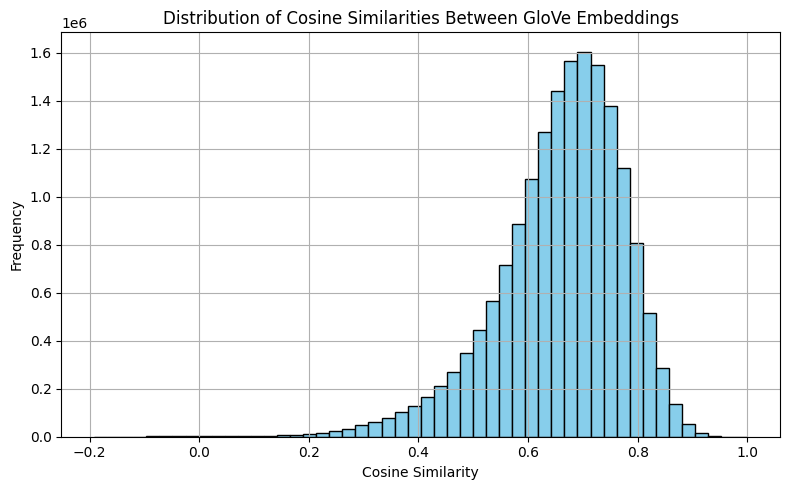

In [6]:
glove_vectors = np.vstack(games["glove_vector"].values)

# Compute the full cosine similarity matrix
sim_matrix = cosine_similarity(glove_vectors)

# Remove diagonal values (self-similarity)
np.fill_diagonal(sim_matrix, np.nan)

# Flatten and filter out NaNs
similarities = sim_matrix[~np.isnan(sim_matrix)]

# Plot histogram
plt.figure(figsize=(8, 5))
plt.hist(similarities, bins=50, color="skyblue", edgecolor="black")
plt.title("Distribution of Cosine Similarities Between GloVe Embeddings")
plt.xlabel("Cosine Similarity")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

From this histogram, we can learn different things, some along the lines of:

1.   Most pair have high similarity scores, grouped between 0.7 and 0.8, which may be telling us that many game descriptions are using similar language or concepts.
2.   Very few pairs are below 0.6, transalting into strong dissimilarities in descriptions being rare.

These results can be interpreted in different ways, because if we were show that there is a semantic consistency, these results would confirm it.

However, if our goal is to detect meaningful clusters or differentiate games precisely, since everything is mostly 85%-95% similar, we are not getting much variation.

Because of this, we will try and enhance GloVe by trying a contextual embedding such as BERT and combining text with some more metadata.

As of right now, let's take a deeper look to our embeddings.


In [7]:
def get_min_max_similarity(games_df):
    # Stack GloVe vectors into a 2D array
    vectors = np.vstack(games_df["glove_vector"].values)

    # Compute full cosine similarity matrix
    sim_matrix = cosine_similarity(vectors)

    # Remove diagonal (similarity with self = 1.0)
    np.fill_diagonal(sim_matrix, np.nan)

    # Get min and max ignoring NaNs
    min_sim = np.nanmin(sim_matrix)
    max_sim = np.nanmax(sim_matrix)
    mean_sim = np.nanmean(sim_matrix)

    return min_sim, max_sim, mean_sim

In [8]:
min_similarity, max_similarity, mean = get_min_max_similarity(games)
print(f"Min similarity: {min_similarity:.4f}, Max similarity: {max_similarity:.4f}")
print(mean)

Min similarity: -0.1917, Max similarity: 1.0000
0.658546525084459


In [9]:
def get_min_max_similarity_with_ids(games_df):
    # Stack GloVe vectors into a 2D array
    vectors = np.vstack(games_df["glove_vector"].values)

    # Compute full cosine similarity matrix
    sim_matrix = cosine_similarity(vectors)

    # Remove diagonal (self-similarity)
    np.fill_diagonal(sim_matrix, np.nan)

    # Get min, max, and mean ignoring NaNs
    min_sim = np.nanmin(sim_matrix)
    max_sim = np.nanmax(sim_matrix)
    mean_sim = np.nanmean(sim_matrix)

    # Get indices of min and max
    min_indices = np.unravel_index(np.nanargmin(sim_matrix), sim_matrix.shape)
    max_indices = np.unravel_index(np.nanargmax(sim_matrix), sim_matrix.shape)

    # Get IDs and names
    min_pair = (games_df.iloc[min_indices[0]]["id"], games_df.iloc[min_indices[1]]["id"])
    max_pair = (games_df.iloc[max_indices[0]]["id"], games_df.iloc[max_indices[1]]["id"])

    return min_sim, max_sim, mean_sim, min_pair, max_pair

In [10]:
min_sim, max_sim, mean_sim, min_pair, max_pair = get_min_max_similarity_with_ids(games)
print(f"Min similarity: {min_sim:.4f} between games {min_pair}")
print(f"Max similarity: {max_sim:.4f} between games {max_pair}")
print(f"Mean similarity: {mean_sim:.4f}")

min_names = (games[games["id"] == min_pair[0]]["name"].values[0],
             games[games["id"] == min_pair[1]]["name"].values[0])
max_names = (games[games["id"] == max_pair[0]]["name"].values[0],
             games[games["id"] == max_pair[1]]["name"].values[0])
print(f"Min similarity between: {min_names}")
print(f"Max similarity between: {max_names}")

Min similarity: -0.1917 between games (5450, 5574)
Max similarity: 1.0000 between games (3000, 3000)
Mean similarity: 0.6585
Min similarity between: ('Surprise Attack!', 'Trigon Chess & Checkers')
Max similarity between: ('1806: Rossbach Avenged', '1806: Rossbach Avenged')


Here we see the games with the least similarity. In these games, the description is highly uninformative.

In [11]:
print(games[games['id'] == 2286]['clean_description'].values[0])
print(games[games['id'] == 2473]['clean_description'].values[0])

expand new change creation new star simple campaign system skill system new race background description af famous team star card blood bowl second edition microbadge blood bowl fan blood bowl fan blood bowl fan blood bowl fan human blood bowl fan norse blood bowl team manager card fan blood bowl fan chaos dwarve blood bowl fan orcs amp goblins blood bowl fan chaos blood bowl fan amazon blood bowl fan halfling blood bowl fan vampire blood bowl fan dwarve blood bowl fan dark elve blood bowl fan skaven blood bowl fan elve blood bowl fan wood elve blood bowl fan lizardman blood bowl fan undead expand blood bowl second edition
winkeladvokat abstract implement cabale


##### GloVe + Metadata

Now that we have explored similarity using only text (via GloVe), we can try and add  metadata features to enrich our similarity analysis.

We selected some additional features that might influence how games relate to each other, such as the number of players, game complexity...

In [12]:
extra_features = ["year", "rating", "complexity", "minplayers", "maxplayers", "playingtime", "minage"]

# Initialize the scaler
scaler = MinMaxScaler()

# Fit and transform
games_scaled_features = scaler.fit_transform(games[extra_features])

# Save them into a new column
games["extra_vector"] = list(games_scaled_features)

In [13]:
# Now we combine the textual (GloVe) vector and the extra features into a single vector.
# Each game is now represented by a vector that includes both semantic and numeric information.
games["combined_vector"] = games.apply(
    lambda row: np.concatenate([row["glove_vector"], row["extra_vector"]]),
    axis=1)

In [14]:
len(games['combined_vector'][0])

307

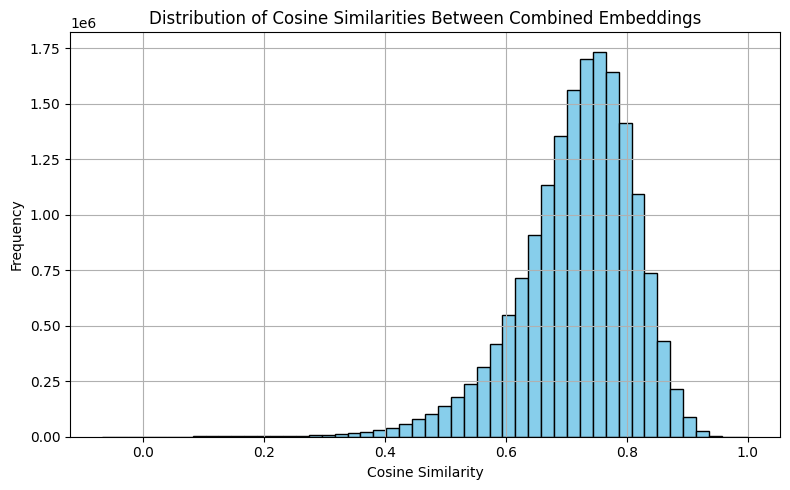

In [15]:
combined_vectors = np.vstack(games["combined_vector"].values)

# Compute the full cosine similarity matrix
sim_matrix = cosine_similarity(combined_vectors)

# Remove diagonal values (self-similarity)
np.fill_diagonal(sim_matrix, np.nan)

# Flatten and filter out NaNs
similarities = sim_matrix[~np.isnan(sim_matrix)]

plt.figure(figsize=(8, 5))
plt.hist(similarities, bins=50, color="skyblue", edgecolor="black")
plt.title("Distribution of Cosine Similarities Between Combined Embeddings")
plt.xlabel("Cosine Similarity")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

When comparing the similarity histograms, we find that using GloVe alone provides a broader range of similarity scores between games. It captures meaningful differences in game descriptions, making it more effective for differentiating games.

Aadding extra features like year, rating, and player count reduces variability in similarity scores, making most games to appear overly similar. This limits the model's ability to differentiate between games, making the combined approach less useful in our context.

In [16]:
games[games['name']== 'Siesta']

id    name                                        description  year  \
374  608  Siesta  This abstract boardgame is made completely of ...  1999   

     rating  complexity  minplayers  maxplayers  playingtime  minage  \
374  6.3504        2.52           2           4           70      10   

            categories  description_length  \
374  Abstract Strategy                 134   

                                     clean_description  \
374  abstract boardgame completely wood beautiful o...   

                                       glove_vector100  \
374  [-0.21252301  0.3517719   0.18941957  0.039183...   

                                          glove_vector predicted_emotion  \
374  [-0.0617233925, 0.00413050782, 0.0266195908, -...           intense   

    predicted_vibe                                       extra_vector  \
374    competitive  [0.9974062250598563, 0.6684631578947368, 0.504...   

                                       combined_vector  
374  [-0.0617233925, 0.00413050782, 0.0266195908, -...

In [17]:
games[games['name']== 'CATAN']

id   name                                        description  year  \
12  13  CATAN  In CATAN (formerly The Settlers of Catan), pla...  1995   

     rating  complexity  minplayers  maxplayers  playingtime  minage  \
12  7.09405      2.2875           3           4          120      10   

               categories  description_length  \
12  Economic, Negotiation                 330   

                                    clean_description  \
12  catan settler catan dominant force island cata...   

                                      glove_vector100  \
12  [-0.25286663  0.25391874  0.1490025   0.055884...   

                                         glove_vector predicted_emotion  \
12  [-0.145800844, 0.0785744861, -0.0883872509, -0...              dark   

   predicted_vibe                                       extra_vector  \
12    competitive  [0.996608140462889, 0.7467421052631579, 0.4575...   

                                      combined_vector  
12  [-0.145800844, 0.0785744861, -0.0883872509, -0...

In [18]:
def compare_games_combined_similarity(game_id_1, game_id_2, games_df):
    # Get combined vectors
    vec1 = games_df.loc[games_df["id"] == game_id_1, "combined_vector"].values[0]
    vec2 = games_df.loc[games_df["id"] == game_id_2, "combined_vector"].values[0]

    # Get descriptions
    desc1 = games_df.loc[games_df["id"] == game_id_1, "clean_description"].values[0]
    desc2 = games_df.loc[games_df["id"] == game_id_2, "clean_description"].values[0]

    # Compute cosine similarity
    sim = cosine_similarity([vec1], [vec2])[0][0]

    # Print the results
    print(f"Cosine similarity between Game {game_id_1} and Game {game_id_2}: {sim:.4f}")
    print(f"\nDescription of Game {game_id_1}: {desc1}")
    print(f"\nDescription of Game {game_id_2}: {desc2}")

In [19]:
# Example usage
compare_games_combined_similarity(game_id_1=171, game_id_2=13, games_df=games)

Cosine similarity between Game 171 and Game 13: 0.8032

Description of Game 171: chess abstract strategy board represent medieval warfare x board alternate light dark square oppose piece traditionally designate white black initially line board type piece unique form movement capturing occur piece movement occupy square oppose piece piece attempt capture attack defend develop position chess checkmate king escape opponent piece resignation recognize defeat inevitable type draw chess popular world million people worldwide home club online correspondence tournament highly skilled chess beautiful thing watch provide great entertainment novice netflix series queen gambit enjoy chess non alike large literature book periodical chess typically feature commentary chess master chess known highly regard metaphor journalism poetry fiction film chess origin indian chaturanga shatranj introduce persian current form emerge second half th century persian bring shatranj southern europe tradition organiz

##### BERT

Finally, we explore BERT to represent each game's description. Unlike GloVe, which uses static word vectors, BERT captures contextual meaning, allowing us to better differentiate between similar words used in different contexts.



In [20]:
# Load pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertModel.from_pretrained("bert-base-uncased")
model.eval()  # Set model to evaluation mode

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

We have defined a function that takes in a game description and returns a 768-dimensional embedding representing the entire sentence. We do this by extracting the embedding of the special CLS token, which BERT is trained to use as a summary of the sentence.

In [21]:
def get_bert_embeddings(texts, tokenizer, model, batch_size=16, device="cpu"):
    model.to(device)
    model.eval()
    embeddings = []

    dataloader = DataLoader(texts, batch_size=batch_size)

    with torch.no_grad():
        for batch in tqdm(dataloader):
            inputs = tokenizer(batch, return_tensors="pt", padding=True, truncation=True, max_length=128).to(device)
            outputs = model(**inputs)
            cls_embeddings = outputs.last_hidden_state[:, 0, :]  # shape: (batch_size, 768)
            embeddings.extend(cls_embeddings.cpu().numpy())

    return embeddings

In [22]:
texts = games["clean_description"].tolist()
bert_vectors = get_bert_embeddings(texts, tokenizer, model, batch_size=16, device="cuda" if torch.cuda.is_available() else "cpu")
games["bert_vector"] = bert_vectors

100%|██████████| 258/258 [00:41<00:00,  6.24it/s]


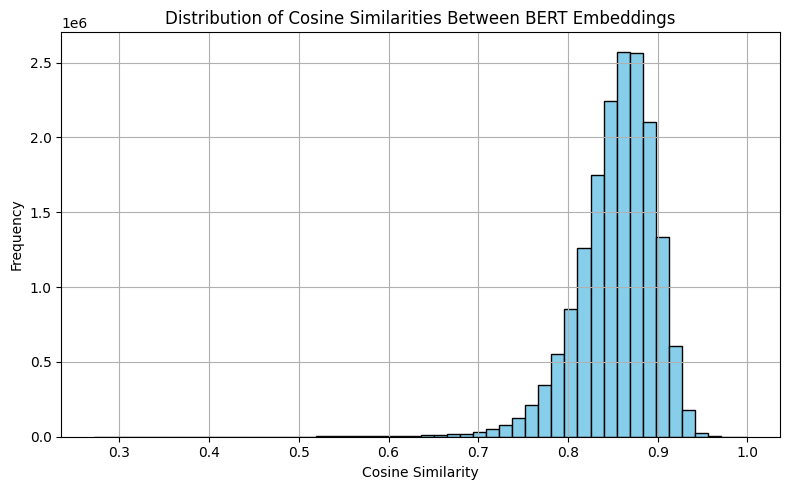

In [23]:
bert_vectors = np.vstack(games["bert_vector"].values)

# Compute the full cosine similarity matrix
sim_matrix = cosine_similarity(bert_vectors)

# Remove diagonal values (self-similarity)
np.fill_diagonal(sim_matrix, np.nan)

# Flatten and filter out NaNs
similarities = sim_matrix[~np.isnan(sim_matrix)]


plt.figure(figsize=(8, 5))
plt.hist(similarities, bins=50, color="skyblue", edgecolor="black")
plt.title("Distribution of Cosine Similarities Between BERT Embeddings")
plt.xlabel("Cosine Similarity")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

Now we try S-BERT, which produces sentence-level embeddings using transformers and attention mechanisms, allowing it to encode deeper semantic relationships.

In [24]:
# Load SBERT model (MiniLM is fast and effective)
sbert_model = SentenceTransformer('all-MiniLM-L6-v2')

# Compute embeddings
texts = games["clean_description"].tolist()
sbert_embeddings = sbert_model.encode(texts, batch_size=16, show_progress_bar=True)

games["bert_vector"] = list(sbert_embeddings)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/258 [00:00<?, ?it/s]

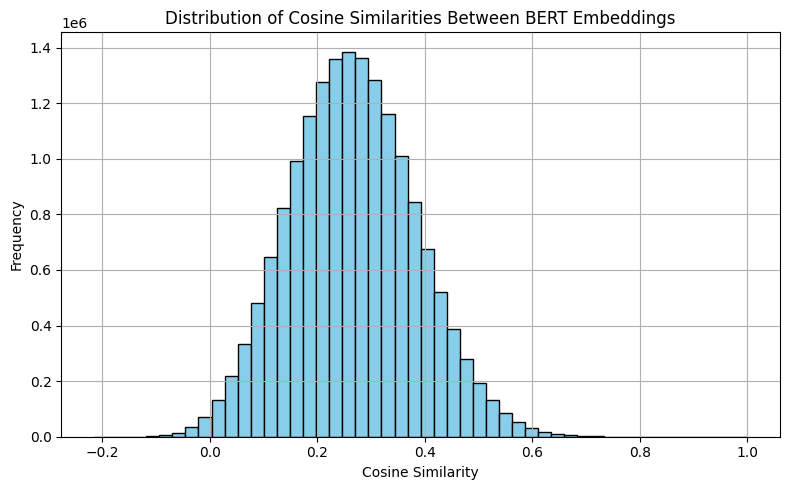

In [25]:
bert_vectors = np.vstack(games["bert_vector"].values)

# Compute the full cosine similarity matrix
sim_matrix = cosine_similarity(bert_vectors)

# Remove diagonal values (self-similarity)
np.fill_diagonal(sim_matrix, np.nan)

# Flatten and filter out NaNs
similarities = sim_matrix[~np.isnan(sim_matrix)]

# Plot histogram
plt.figure(figsize=(8, 5))
plt.hist(similarities, bins=50, color="skyblue", edgecolor="black")
plt.title("Distribution of Cosine Similarities Between BERT Embeddings")
plt.xlabel("Cosine Similarity")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

As observed in the distribution from above, the SBERT provides more discriminative power across descriptions.

#### Reviews Dataset Exploration

Now we explore the dataset of user reviews to understand how many games have been reviewed, the distribution of ratings, and user activity.

In [26]:
# Basic overview
print("First 5 rows:")
print(reviews.head())

print("\nInfo:")
print(reviews.info())

First 5 rows:
   Unnamed: 0         user  rating  \
0           0   sidehacker    10.0   
1           1  Varthlokkur    10.0   
2           2   dougthonus    10.0   
3           3       cypar7    10.0   
4           4      ssmooth    10.0   

                                             comment  ID   name  
0                                                NaN  13  CATAN  
1                                                NaN  13  CATAN  
2  Currently, this sits on my list as my favorite...  13  CATAN  
3  I know it says how many plays, but many, many ...  13  CATAN  
4                                                NaN  13  CATAN  

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1872440 entries, 0 to 1872439
Data columns (total 6 columns):
 #   Column      Dtype  
---  ------      -----  
 0   Unnamed: 0  int64  
 1   user        object 
 2   rating      float64
 3   comment     object 
 4   ID          int64  
 5   name        object 
dtypes: float64(1), int64(2), object(3)
me

In [27]:
print("\nSummary statistics:")
print(reviews.describe(include='all'))


Summary statistics:
          Unnamed: 0            user        rating comment            ID  \
count   1.872440e+06         1872418  1.872440e+06  392861  1.872440e+06   
unique           NaN          272602           NaN  370335           NaN   
top              NaN  oldgoat3769967           NaN                   NaN   
freq             NaN             828           NaN     539           NaN   
mean    1.132269e+07             NaN  6.831342e+00     NaN  5.107972e+02   
std     7.443265e+06             NaN  1.578301e+00     NaN  5.241667e+02   
min     0.000000e+00             NaN  1.401300e-45     NaN  1.000000e+00   
25%     4.464027e+06             NaN  6.000000e+00     NaN  5.100000e+01   
50%     1.089006e+07             NaN  7.000000e+00     NaN  3.200000e+02   
75%     1.744820e+07             NaN  8.000000e+00     NaN  8.220000e+02   
max     2.619932e+07             NaN  1.000000e+01     NaN  2.119000e+03   

           name  
count   1872440  
unique      990  
top       CA

We observe there are only missing values in the comments

In [28]:
# Check for missing values
print("\nMissing values:")
print(reviews.isnull().sum())


Missing values:
Unnamed: 0          0
user               22
rating              0
comment       1479579
ID                  0
name                0
dtype: int64


In [29]:
# Drop possible rows where the 'user' column is NA
reviews = reviews.dropna(subset=["user"])

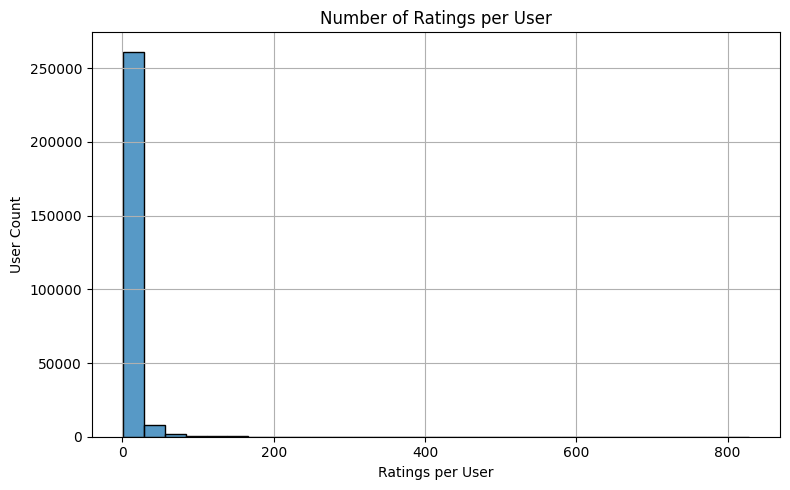

In [30]:
# Number of ratings per user
ratings_per_user = reviews.groupby("user")["rating"].count()
plt.figure(figsize=(8, 5))
sns.histplot(ratings_per_user, bins=30)
plt.title("Number of Ratings per User")
plt.xlabel("Ratings per User")
plt.ylabel("User Count")
plt.grid(True)
plt.tight_layout()
plt.show()

Most of the users have very few ratings, as expected

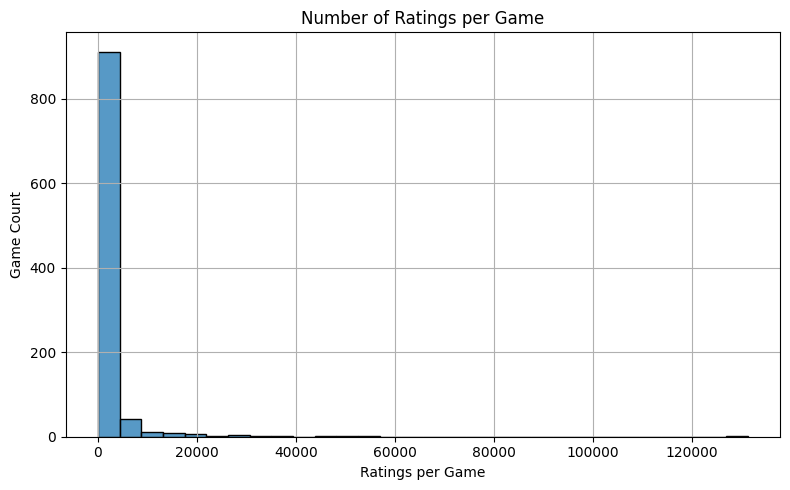

In [31]:
# Number of ratings per game
ratings_per_game = reviews.groupby("ID")["rating"].count()
plt.figure(figsize=(8, 5))
sns.histplot(ratings_per_game, bins=30)
plt.title("Number of Ratings per Game")
plt.xlabel("Ratings per Game")
plt.ylabel("Game Count")
plt.grid(True)
plt.tight_layout()
plt.show()

Besides, most games have also very few reviews, also expected

In [32]:
# Most rated games
top_games = reviews["name"].value_counts().head(10)
print("\nTop 10 most rated games:")
print(top_games)


Top 10 most rated games:
name
CATAN          131302
Carcassonne    131204
Citadels        55609
Bohnanza        48291
Lost Cities     48067
Chess           37913
Risk            36796
Scrabble        33458
For Sale        32173
El Grande       30393
Name: count, dtype: int64


In [33]:
# Unique game names in the reviews
unique_names = reviews["name"].unique()
print(len(unique_names))

990


In [34]:
# Unique reviews of games in the reviews
reviewed_ids = reviews["ID"].unique()

In [35]:
# Find games with and without reviews
games_with_reviews = games[games["id"].isin(reviewed_ids)]
games_without_reviews = games[~games["id"].isin(reviewed_ids)]

In [36]:
print(f"Total games: {len(games)}")
print(f"Games with reviews: {len(games_with_reviews)}")
print(f"Games without reviews: {len(games_without_reviews)}")

Total games: 4122
Games with reviews: 991
Games without reviews: 3131


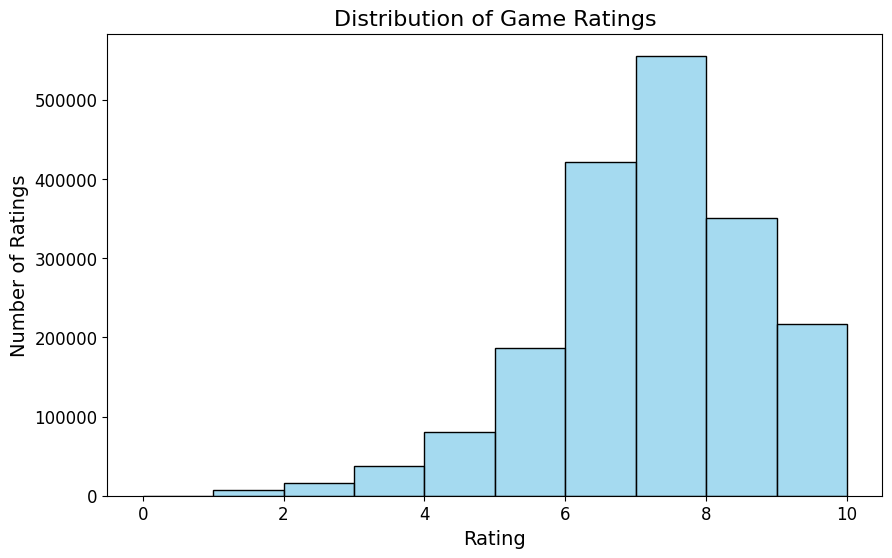

In [37]:
plt.figure(figsize=(10, 6))
sns.histplot(data=reviews, x='rating', bins=10, color='skyblue', edgecolor='black')
plt.xlabel("Rating", fontsize=14)
plt.ylabel("Number of Ratings", fontsize=14)
plt.title("Distribution of Game Ratings", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

This histogram shows the frequency of ratings given to games, on a scale from 0 to 10.

The distribution is right-skewed, meaning most ratings are above 6. Also, the most common rating is between 7 and 8, suggesting that users tend to rate games positively, and very low ratings are rare.

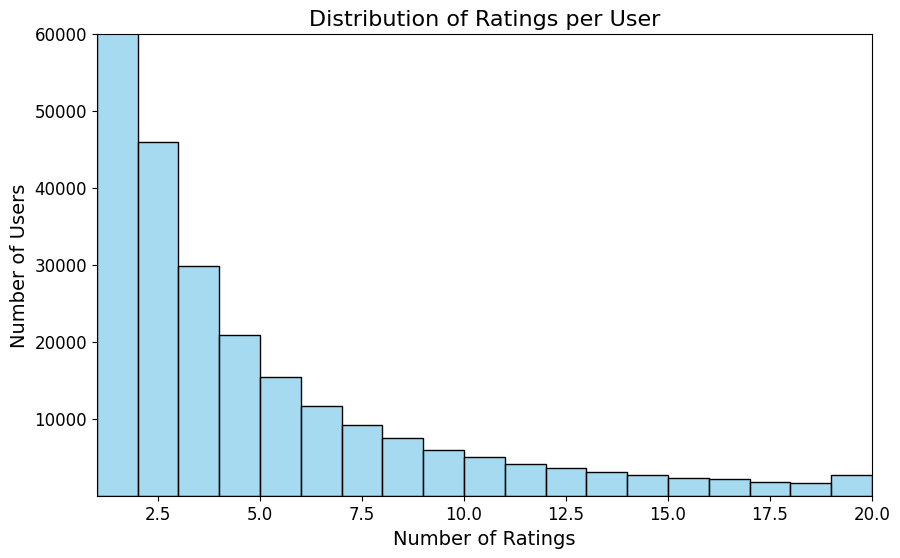

The user who has rated most games has rated: 828


In [38]:
Nrating_por_user = reviews.user.value_counts()

plt.figure(figsize=(10, 6))
sns.histplot(Nrating_por_user, bins=range(1, 21), color='skyblue', edgecolor='black')
plt.xlim(1, 20)
plt.ylim(1, 60000)
plt.xlabel("Number of Ratings", fontsize=14)
plt.ylabel("Number of Users", fontsize=14)
plt.title("Distribution of Ratings per User", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

# Print the user who has rated the most
print("The user who has rated most games has rated:", Nrating_por_user.max())

This histogram shows how many users have given a certain number of ratings.

The majority of users have rated only 1 or 2 games, and very few users have rated more than 10 games, and even fewer above 15.

#### Filtering the reviews

In [39]:
# Keep only reviews for games that exist in the games dataset
valid_game_ids = set(games["id"].unique())
filtered_reviews = reviews[reviews["ID"].isin(valid_game_ids)].copy()
filtered_reviews

Unnamed: 0         user  rating  \
0                 0   sidehacker    10.0   
1                 1  Varthlokkur    10.0   
2                 2   dougthonus    10.0   
3                 3       cypar7    10.0   
4                 4      ssmooth    10.0   
...             ...          ...     ...   
1872435    26199316      Pyrogal     1.0   
1872436    26199317     jbuergel     1.0   
1872437    26199318  feztacular1     1.0   
1872438    26199319     balsak40     1.0   
1872439    26199320   manyslayer     1.0   

                                                   comment    ID  \
0                                                      NaN    13   
1                                                      NaN    13   
2        Currently, this sits on my list as my favorite...    13   
3        I know it says how many plays, but many, many ...    13   
4                                                      NaN    13   
...                                                    ...   ...   
1872435  Total garbage.  This game looks like it was a ...  1546   
1872436  This might be the biggest ripoff I've ever bee...  1546   
1872437             This game is a turd.  Pure and simple.  1546   
1872438                                 Awful, just awful.  1546   
1872439                                                NaN  1546   

                               name  
0                             CATAN  
1                             CATAN  
2                             CATAN  
3                             CATAN  
4                             CATAN  
...                             ...  
1872435  Worlds of Heroes & Tyrants  
1872436  Worlds of Heroes & Tyrants  
1872437  Worlds of Heroes & Tyrants  
1872438  Worlds of Heroes & Tyrants  
1872439  Worlds of Heroes & Tyrants  

[1872418 rows x 6 columns]

In [40]:
# Check the number of reviews per game
review_counts = filtered_reviews["ID"].value_counts()
review_counts.describe()

count       991.000000
mean       1889.422805
std        7491.905499
min          30.000000
25%         106.500000
50%         306.000000
75%        1048.500000
max      131302.000000
Name: count, dtype: float64

In [41]:
filtered_reviews

Unnamed: 0         user  rating  \
0                 0   sidehacker    10.0   
1                 1  Varthlokkur    10.0   
2                 2   dougthonus    10.0   
3                 3       cypar7    10.0   
4                 4      ssmooth    10.0   
...             ...          ...     ...   
1872435    26199316      Pyrogal     1.0   
1872436    26199317     jbuergel     1.0   
1872437    26199318  feztacular1     1.0   
1872438    26199319     balsak40     1.0   
1872439    26199320   manyslayer     1.0   

                                                   comment    ID  \
0                                                      NaN    13   
1                                                      NaN    13   
2        Currently, this sits on my list as my favorite...    13   
3        I know it says how many plays, but many, many ...    13   
4                                                      NaN    13   
...                                                    ...   ...   
1872435  Total garbage.  This game looks like it was a ...  1546   
1872436  This might be the biggest ripoff I've ever bee...  1546   
1872437             This game is a turd.  Pure and simple.  1546   
1872438                                 Awful, just awful.  1546   
1872439                                                NaN  1546   

                               name  
0                             CATAN  
1                             CATAN  
2                             CATAN  
3                             CATAN  
4                             CATAN  
...                             ...  
1872435  Worlds of Heroes & Tyrants  
1872436  Worlds of Heroes & Tyrants  
1872437  Worlds of Heroes & Tyrants  
1872438  Worlds of Heroes & Tyrants  
1872439  Worlds of Heroes & Tyrants  

[1872418 rows x 6 columns]

In [42]:
reviews = filtered_reviews

#### Content-based system

In this section, we will be implementing different content-based recommendation systems that suggest games to users based on the content of games they have previously liked.

These systems rely on vector representations derived from game descriptions, along with optional metadata like player count and playtime, to build personalized user profiles.

We will explore several variants, starting with a basic similarity-based approach and going toward more diverse models using techniques like MMR, clustering, and even emotional tone.

##### Basic content-based system

The first method is a simple content-based recommender that suggests new games to a user based on the descriptions of games they liked.

We consider it 'basic' because it relies solely on semantic similarity between game descriptions, without incorporating diversity mechanisms, clustering, or collaborative data.

This works by using GloVe embeddings to convert each game's description into a numeric vector. Then, for a given user, it builds a preference profile by averaging the vectors of games the user liked, weighted by how highly they were rated. The system then compares this profile to the rest of the games (filtered by user constraints like age or playtime), and recommends the top k games with the highest cosine similarity to the user's profile.


In [43]:
def recommend_content_based_basic(user_name, games, reviews, top_k=10, testing=False, max_playingtime=None, min_age=None, minplayers=None, maxplayers=None, min_rating=None):
    # Filter games based on user preferences
    filtered_games = games.copy()

    if max_playingtime is not None:
        filtered_games = filtered_games[filtered_games["playingtime"] <= max_playingtime]
    if min_age is not None:
        filtered_games = filtered_games[filtered_games["minage"] >= min_age]
    if minplayers is not None:
        filtered_games = filtered_games[filtered_games["minplayers"] <= minplayers]
    if maxplayers is not None:
        filtered_games = filtered_games[filtered_games["maxplayers"] >= maxplayers]
    if min_rating is not None:
        filtered_games = filtered_games[filtered_games["rating"] >= min_rating]

    if filtered_games.empty:
        print("No games match the provided filters.")
        return

    # Get games the user liked
    liked_game_ids = reviews[(reviews["user"] == user_name) & (reviews["rating"] >= 6)]
    liked_vectors = liked_game_ids.merge(games[["id", "glove_vector"]], left_on="ID", right_on="id")

    if liked_vectors.empty:
        print("Not enough liked games with vectors to build a profile.")
        return

    # Build user profile (weighted average)
    ratings = liked_vectors["rating"].values
    weights = ratings / ratings.max()
    vectors = np.vstack(liked_vectors["glove_vector"])
    user_profile = np.average(vectors, axis=0, weights=weights)

    if not testing:
        # Remove already liked games from recommendations
        unseen_mask = ~filtered_games["id"].isin(liked_game_ids["ID"])
        filtered_games = filtered_games[unseen_mask]

    if filtered_games.empty:
        print("No new games to recommend after filtering out liked ones")
        return

    # Calculate similarity
    game_vectors = np.vstack(filtered_games["glove_vector"].values)
    similarities = cosine_similarity(game_vectors, [user_profile]).flatten()

    # Select top_k most similar games
    filtered_games = filtered_games.copy()
    filtered_games["similarity"] = similarities
    recommended_games = filtered_games.sort_values(by="similarity", ascending=False).head(top_k)

    # Generate personalized explanations
    explanations = []
    for game_id in recommended_games["id"]:
        # Find most similar liked game
        similarities_to_liked = cosine_similarity(
            [games.loc[games["id"] == game_id, "glove_vector"].values[0]],
            liked_vectors["glove_vector"].tolist()
        ).flatten()
        most_similar_game_idx = np.argmax(similarities_to_liked)
        most_similar_game_id = liked_game_ids.iloc[most_similar_game_idx]["ID"]
        most_similar_game_name = games.loc[games["id"] == most_similar_game_id, "name"].values[0]
        most_similar_rating = liked_game_ids.iloc[most_similar_game_idx]["rating"]

        # Vibe and emotion
        predicted_vibe = games.loc[games["id"] == game_id, "predicted_vibe"].values[0]
        predicted_emotion = games.loc[games["id"] == game_id, "predicted_emotion"].values[0]

        explanation = (
            f"I recommend this game because you liked '{most_similar_game_name}' "
            f"(you rated it {most_similar_rating}/10). "
            f"This game has a '{predicted_emotion}' feeling and is '{predicted_vibe}'."
        )
        explanations.append(explanation)

    recommended_games["explanation"] = explanations

    return recommended_games[["name", "rating", "id", "similarity", "explanation"]]

In [44]:
user_name = "jbuergel"
recommendations = recommend_content_based_basic(
    user_name,
    games,
    filtered_reviews,
    max_playingtime=60,
    min_age=12,
    minplayers=2,
    maxplayers=4,
    min_rating=6
)

print(f"Recommended games for user '{user_name}'")
print(recommendations)

Recommended games for user 'jbuergel'
                                   name   rating    id  similarity  \
1215   Shadowrun: The Trading Card Game  6.46493  2123    0.950255   
2000                          Holocaust  6.50000  3286    0.943466   
2059                     Santa Fe Rails  6.79856  3348    0.927601   
1221                        On the Edge  6.29387  2135    0.927422   
3904                            Domaine  6.98587  5737    0.926427   
432                       Minion Hunter  6.21185   679    0.923956   
3785  Dungeoneer: Tomb of the Lich Lord  6.09815  5576    0.923302   
1220                               Rage  6.12190  2133    0.918152   
2051                        Hard Vacuum  7.37143  3340    0.914800   
2367                  Mystick Companion  6.62381  3772    0.910238   

                                            explanation  
1215  I recommend this game because you liked 'The G...  
2000  I recommend this game because you liked 'Paths...  
2059  I recommend

In [45]:
if recommendations is not None:
    for idx, row in recommendations.iterrows():
        print(f"{row['name']} (Rating: {row['rating']:.2f})")
        print(f"Similarity: {row['similarity']:.2f}")
        print(f"{row['explanation']}\n")

Shadowrun: The Trading Card Game (Rating: 6.46)
Similarity: 0.95
I recommend this game because you liked 'The Great Khan Game' (you rated it 7.0/10). This game has a 'serious' feeling and is 'strategic'.

Holocaust (Rating: 6.50)
Similarity: 0.94
I recommend this game because you liked 'Paths of Glory' (you rated it 6.0/10). This game has a 'dark' feeling and is 'competitive'.

Santa Fe Rails (Rating: 6.80)
Similarity: 0.93
I recommend this game because you liked 'Bus' (you rated it 7.0/10). This game has a 'dark' feeling and is 'competitive'.

On the Edge (Rating: 6.29)
Similarity: 0.93
I recommend this game because you liked 'The Great Khan Game' (you rated it 7.0/10). This game has a 'funny' feeling and is 'strategic'.

Domaine (Rating: 6.99)
Similarity: 0.93
I recommend this game because you liked 'The Great Khan Game' (you rated it 7.0/10). This game has a 'dark' feeling and is 'competitive'.

Minion Hunter (Rating: 6.21)
Similarity: 0.92
I recommend this game because you liked 'R

##### MMR diversity content-based system

In this method, we extend the basic content-based recommender by incorporating a diversitystrategy known as Maximal Marginal Relevance (MMR).

While the basic model focuses only on recommending games that are most similar to the user's profile, it can result in suggestions that are too similar to each other.

MMR addresses this by balancing relevance (similarity to the user) with diversity (dissimilarity among recommended items). At each step, the algorithm selects the next best game that is both similar to the user's interests and sufficiently different from previously selected games.

This allows us to give recommendations that are not only aligned with the user's tastes but also more varied.

In [46]:
def mmr(user_profile, candidate_vectors, candidate_ids, lambda_param=0.7, top_k=10):
    selected = []
    selected_ids = []
    candidate_indices = list(range(len(candidate_vectors)))

    similarities_to_user = cosine_similarity(candidate_vectors, [user_profile]).flatten()
    similarity_matrix = cosine_similarity(candidate_vectors)

    for _ in range(top_k):
        mmr_scores = []
        for idx in candidate_indices:
            if not selected:
                diversity_penalty = 0
            else:
                diversity_penalty = max(similarity_matrix[idx][j] for j in selected)

            mmr_score = lambda_param * similarities_to_user[idx] - (1 - lambda_param) * diversity_penalty
            mmr_scores.append((idx, mmr_score))

        selected_idx, _ = max(mmr_scores, key=lambda x: x[1])
        selected.append(selected_idx)
        selected_ids.append(candidate_ids[selected_idx])
        candidate_indices.remove(selected_idx)

    return selected_ids

In [47]:
def visualize_mmr(user_vector, candidate_vectors, candidate_ids, game_names, lambda_param=0.7, top_k=10):
    # Get top-k by similarity
    relevance = cosine_similarity(candidate_vectors, [user_vector]).flatten()
    top_k_indices = relevance.argsort()[::-1][:top_k]
    top_k_ids = [candidate_ids[i] for i in top_k_indices]

    # Get top-k using MMR
    mmr_ids = mmr(user_vector, candidate_vectors, candidate_ids, lambda_param, top_k)

    # Reduce dimensions for plotting
    pca = PCA(n_components=2)
    reduced = pca.fit_transform(np.vstack([user_vector, candidate_vectors]))
    user_p = reduced[0]
    candidates_p = reduced[1:]

    plt.figure(figsize=(10, 7))
    plt.scatter(candidates_p[:, 0], candidates_p[:, 1], c='lightgray', label="All Candidates", alpha=0.5)

    # Plot user profile
    plt.scatter(user_p[0], user_p[1], c='blue', label="User Profile", marker='X', s=100)

    # Plot top-k by similarity
    for idx in top_k_indices:
        plt.scatter(candidates_p[idx, 0], candidates_p[idx, 1], c='green', label="Top-k Similarity" if idx == top_k_indices[0] else "", edgecolors='black')
        plt.text(candidates_p[idx, 0], candidates_p[idx, 1], game_names[candidate_ids[idx]], fontsize=8, color='darkgreen')

    # Plot MMR-selected games
    for mmr_id in mmr_ids:
        i = candidate_ids.index(mmr_id)
        plt.scatter(candidates_p[i, 0], candidates_p[i, 1], c='orange', label="Top-k MMR" if mmr_id == mmr_ids[0] else "", edgecolors='black')
        plt.text(candidates_p[i, 0], candidates_p[i, 1], game_names[mmr_id], fontsize=8, color='darkorange')

    plt.legend()
    plt.title(f"MMR vs Top-k Similarity (λ = {lambda_param})")
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.grid(True)
    plt.show()

In [48]:
def recommend_content_based_mmr(user_name, games, reviews, top_k=10, testing=False, max_playingtime=None, min_age=None, minplayers=None, maxplayers=None, min_rating=6, plot=False):
    # Filter games based on user preferences
    filtered_games = games.copy()

    if max_playingtime is not None:
        filtered_games = filtered_games[filtered_games["playingtime"] <= max_playingtime]
    if min_age is not None:
        filtered_games = filtered_games[filtered_games["minage"] >= min_age]
    if minplayers is not None:
        filtered_games = filtered_games[filtered_games["minplayers"] <= minplayers]
    if maxplayers is not None:
        filtered_games = filtered_games[filtered_games["maxplayers"] >= maxplayers]
    if min_rating is not None:
        filtered_games = filtered_games[filtered_games["rating"] >= min_rating]

    if filtered_games.empty:
        print("No games match the provided filters.")
        return

    # Get games the user liked
    liked_game_ids = reviews[(reviews["user"] == user_name) & (reviews["rating"] >= 6)]
    liked_vectors = liked_game_ids.merge(games[["id", "glove_vector"]], left_on="ID", right_on="id")

    if liked_vectors.empty:
        print("Not enough liked games with vectors to build a profile.")
        return

    # Build user profile (weighted average)
    ratings = liked_vectors["rating"].values
    weights = ratings / ratings.max()
    vectors = np.vstack(liked_vectors["glove_vector"])
    user_profile = np.average(vectors, axis=0, weights=weights)

    if not testing:
        # Remove already liked games from recommendations
        unseen_mask = ~filtered_games["id"].isin(liked_game_ids["ID"])
        filtered_games = filtered_games[unseen_mask]

    if filtered_games.empty:
        print("No new games to recommend after filtering out liked ones.")
        return

    # Prepare data for MMR
    game_vectors = np.vstack(filtered_games["glove_vector"].values)
    similarities = cosine_similarity(game_vectors, [user_profile]).flatten()

    # Apply MMR for diversity
    selected_ids = mmr(user_profile, game_vectors, filtered_games["id"].tolist(), lambda_param=0.7, top_k=top_k)
    recommended_games = filtered_games[filtered_games["id"].isin(selected_ids)].copy()

    # Add similarity score for interpretability
    recommended_games["similarity"] = similarities[[filtered_games["id"].tolist().index(i) for i in selected_ids]]

    # Generate personalized explanations with vibe and emotion
    explanations = []
    for game_id in selected_ids:
        # Find the most similar liked game
        similarities_to_liked_games = cosine_similarity([games.loc[games["id"] == game_id, "glove_vector"].values[0]], liked_vectors["glove_vector"].tolist()).flatten()
        most_similar_game_idx = np.argmax(similarities_to_liked_games)
        most_similar_game_id = liked_game_ids.iloc[most_similar_game_idx]["ID"]
        most_similar_game_name = games.loc[games["id"] == most_similar_game_id, "name"].values[0]
        most_similar_rating = liked_game_ids.iloc[most_similar_game_idx]["rating"]

        # Get predicted vibe and emotion for the recommended game
        predicted_vibe = games.loc[games["id"] == game_id, "predicted_vibe"].values[0]
        predicted_emotion = games.loc[games["id"] == game_id, "predicted_emotion"].values[0]

        # Generate the explanation
        explanation = (
            f"I recommend this game because you liked '{most_similar_game_name}' "
            f"(you rated it {most_similar_rating}/10). "
            f"This game has a '{predicted_emotion}' feeling and is '{predicted_vibe}'."
        )
        explanations.append(explanation)

    recommended_games["explanation"] = explanations

    if plot:
        visualize_mmr(user_profile, game_vectors, filtered_games["id"].tolist(), dict(zip(games["id"], games["name"])), lambda_param=0.7, top_k=top_k)

    return recommended_games[["name", "rating", "id", "similarity", "explanation"]]

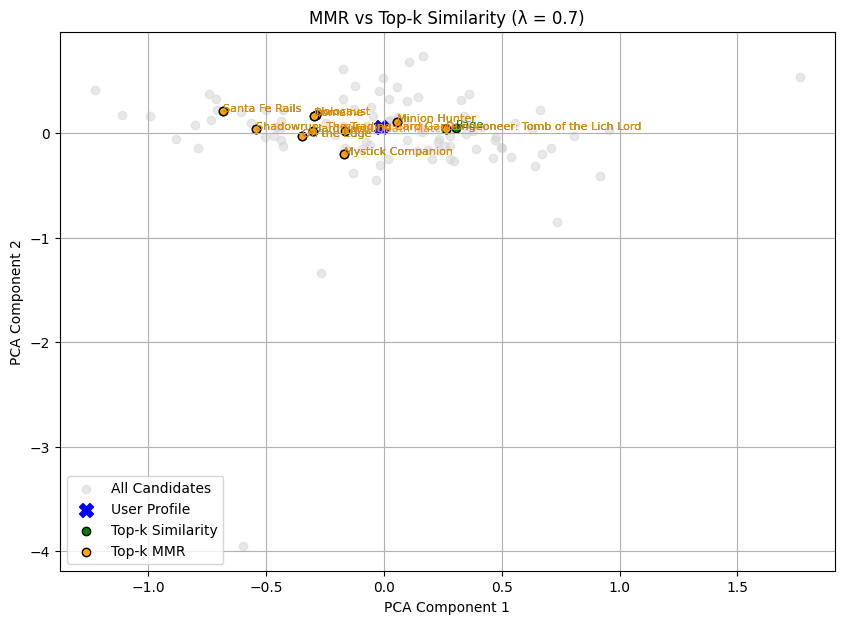

Recommended games for user 'jbuergel'
                                   name   rating    id  similarity  \
432                       Minion Hunter  6.21185   679    0.950255   
1215   Shadowrun: The Trading Card Game  6.46493  2123    0.927601   
1221                        On the Edge  6.29387  2135    0.943466   
1463                  Frag: Death Match  6.34857  2475    0.923956   
2000                          Holocaust  6.50000  3286    0.926427   
2051                        Hard Vacuum  7.37143  3340    0.910238   
2059                     Santa Fe Rails  6.79856  3348    0.923302   
2367                  Mystick Companion  6.62381  3772    0.914800   
3785  Dungeoneer: Tomb of the Lich Lord  6.09815  5576    0.906510   
3904                            Domaine  6.98587  5737    0.927422   

                                            explanation  
432   I recommend this game because you liked 'The G...  
1215  I recommend this game because you liked 'Bus' ...  
1221  I recommend

In [49]:
user_name = "jbuergel"
recommendations = recommend_content_based_mmr(
    user_name,
    games,
    filtered_reviews,
    max_playingtime=60,
    min_age=12,
    minplayers=2,
    maxplayers=4,
    min_rating=6,
    plot = True)

print(f"Recommended games for user '{user_name}'")
print(recommendations)

In [50]:
if recommendations is not None:
    for idx, row in recommendations.iterrows():
        print(f"{row['name']} (Rating: {row['rating']:.2f})")
        print(f"Similarity: {row['similarity']:.2f}")
        print(f"{row['explanation']}\n")

Minion Hunter (Rating: 6.21)
Similarity: 0.95
I recommend this game because you liked 'The Great Khan Game' (you rated it 7.0/10). This game has a 'serious' feeling and is 'strategic'.

Shadowrun: The Trading Card Game (Rating: 6.46)
Similarity: 0.93
I recommend this game because you liked 'Bus' (you rated it 7.0/10). This game has a 'dark' feeling and is 'competitive'.

On the Edge (Rating: 6.29)
Similarity: 0.94
I recommend this game because you liked 'Paths of Glory' (you rated it 6.0/10). This game has a 'dark' feeling and is 'competitive'.

Frag: Death Match (Rating: 6.35)
Similarity: 0.92
I recommend this game because you liked 'RoboRally' (you rated it 8.0/10). This game has a 'dark' feeling and is 'cooperative'.

Holocaust (Rating: 6.50)
Similarity: 0.93
I recommend this game because you liked 'The Great Khan Game' (you rated it 7.0/10). This game has a 'dark' feeling and is 'competitive'.

Hard Vacuum (Rating: 7.37)
Similarity: 0.91
I recommend this game because you liked 'And

##### Cluster diversity content-based system

This other method introduces diversity by grouping candidate games into clusters before selecting recommendations. Instead of simply picking the most similar games overall, we first apply K-Means clustering to partition the games into different groups based on their GloVe embeddings.

Then, we select top candidates from multiple clusters, ensuring that the recommendations are not only relevant to the user's preferences but also draen from different thematic areas within the dataset.

In [51]:
def visualize_clusters(user_profile, game_vectors, cluster_labels, candidate_ids, recommended_ids, id_to_name):
    # Reduce dimensions with PCA
    pca = PCA(n_components=2)
    all_points = np.vstack([user_profile, game_vectors])
    pca_result = pca.fit_transform(all_points)

    user_pca = pca_result[0]
    games_pca = pca_result[1:]

    plt.figure(figsize=(10, 7))

    # Plot games, colored by cluster
    for cluster in np.unique(cluster_labels):
        idxs = np.where(cluster_labels == cluster)[0]
        plt.scatter(games_pca[idxs, 0], games_pca[idxs, 1], label=f"Cluster {cluster}", alpha=0.6)

    # Highlight recommended games and display their names below
    recommended_idxs = [candidate_ids.index(i) for i in recommended_ids if i in candidate_ids]
    for idx in recommended_idxs:
        x, y = games_pca[idx, 0], games_pca[idx, 1]
        plt.scatter(x, y, s=20, color='black')  # Black dot for recommended games
        # Display the game name below the point
        plt.text(x, y - 0.05, id_to_name[candidate_ids[idx]], fontsize=10, color='black', ha='center')

    # Plot user profile
    plt.scatter(user_pca[0], user_pca[1], color='red', s=150, marker='X', label='User Profile')

    # Set the plot labels and title
    plt.xlabel("PCA 1", fontsize=14)
    plt.ylabel("PCA 2", fontsize=14)
    plt.title("PCA Projection of Game Clusters", fontsize=16)

    # Add legend and grid
    plt.legend(loc="best", fontsize=12)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)

    # Show the plot
    plt.show()

In [52]:
def recommend_content_based_cluster(user_name, games, reviews, top_k=10, testing = False, max_playingtime=None, min_age=None, minplayers=None, maxplayers=None, min_rating=None, n_clusters=5, plot=False):
    # Filter games based on user preferences
    filtered_games = games.copy()

    if max_playingtime is not None:
        filtered_games = filtered_games[filtered_games["playingtime"] <= max_playingtime]
    if min_age is not None:
        filtered_games = filtered_games[filtered_games["minage"] >= min_age]
    if minplayers is not None:
        filtered_games = filtered_games[filtered_games["minplayers"] <= minplayers]
    if maxplayers is not None:
        filtered_games = filtered_games[filtered_games["maxplayers"] >= maxplayers]
    if min_rating is not None:
        filtered_games = filtered_games[filtered_games["rating"] >= min_rating]

    if filtered_games.empty:
        print("No games match the provided filters.")
        return

    # Get games the user liked
    liked_game_ids = reviews[(reviews["user"] == user_name) & (reviews["rating"] >= 6)]
    liked_vectors = liked_game_ids.merge(games[["id", "glove_vector"]], left_on="ID", right_on="id")

    if liked_vectors.empty:
        print("Not enough liked games with vectors to build a profile.")
        return

    # Build user profile (weighted average)
    ratings = liked_vectors["rating"].values
    weights = ratings / ratings.max()
    vectors = np.vstack(liked_vectors["glove_vector"])
    user_profile = np.average(vectors, axis=0, weights=weights)

    if not testing:
    # Remove already liked games from recommendations
        unseen_mask = ~filtered_games["id"].isin(liked_game_ids["ID"])
        filtered_games = filtered_games[unseen_mask]

    if filtered_games.empty:
        print("No new games to recommend after filtering out liked ones")
        return

    # Cluster candidate games
    game_vectors = np.vstack(filtered_games["glove_vector"].values)
    candidate_ids = filtered_games["id"].tolist()
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(game_vectors)

    # Compute similarities
    similarities = cosine_similarity(game_vectors, [user_profile]).flatten()

    # Pick top games from each cluster
    cluster_recommendations = []
    for cluster_id in range(n_clusters):
        indices_in_cluster = np.where(cluster_labels == cluster_id)[0]
        if len(indices_in_cluster) == 0:
            continue
        # Sort games in cluster by similarity
        cluster_sims = similarities[indices_in_cluster]
        sorted_idx = indices_in_cluster[np.argsort(cluster_sims)[::-1]]
        for i in sorted_idx[:min(top_k // n_clusters + 1, len(sorted_idx))]:
            cluster_recommendations.append((candidate_ids[i], similarities[i]))

    # Sort all selected games by similarity and return top_k
    sorted_final = sorted(cluster_recommendations, key=lambda x: x[1], reverse=True)[:top_k]
    selected_ids = [x[0] for x in sorted_final]

    recommended_games = filtered_games[filtered_games["id"].isin(selected_ids)].copy()
    recommended_games["similarity"] = [x[1] for x in sorted_final]

    # Generate personalized explanations with vibe and emotion
    explanations = []
    for game_id in selected_ids:
        # Find the most similar liked game
        similarities_to_liked_games = cosine_similarity(
            [games.loc[games["id"] == game_id, "glove_vector"].values[0]],
            liked_vectors["glove_vector"].tolist()
        ).flatten()
        most_similar_game_idx = np.argmax(similarities_to_liked_games)
        most_similar_game_id = liked_game_ids.iloc[most_similar_game_idx]["ID"]
        most_similar_game_name = games.loc[games["id"] == most_similar_game_id, "name"].values[0]
        most_similar_rating = liked_game_ids.iloc[most_similar_game_idx]["rating"]

        # Get predicted vibe and emotion for the recommended game
        predicted_vibe = games.loc[games["id"] == game_id, "predicted_vibe"].values[0]
        predicted_emotion = games.loc[games["id"] == game_id, "predicted_emotion"].values[0]

        # Generate the explanation
        explanation = (
            f"I recommend this game because you liked '{most_similar_game_name}' "
            f"(you rated it {most_similar_rating}/10). "
            f"This game has a '{predicted_emotion}' feeling and is '{predicted_vibe}'."
        )
        explanations.append(explanation)

    recommended_games["explanation"] = explanations

    if plot:
        id_to_name = dict(zip(games["id"], games["name"]))
        visualize_clusters(user_profile, game_vectors, cluster_labels, candidate_ids, selected_ids, id_to_name)

    return recommended_games[["name", "rating", "id", "similarity", "explanation"]]

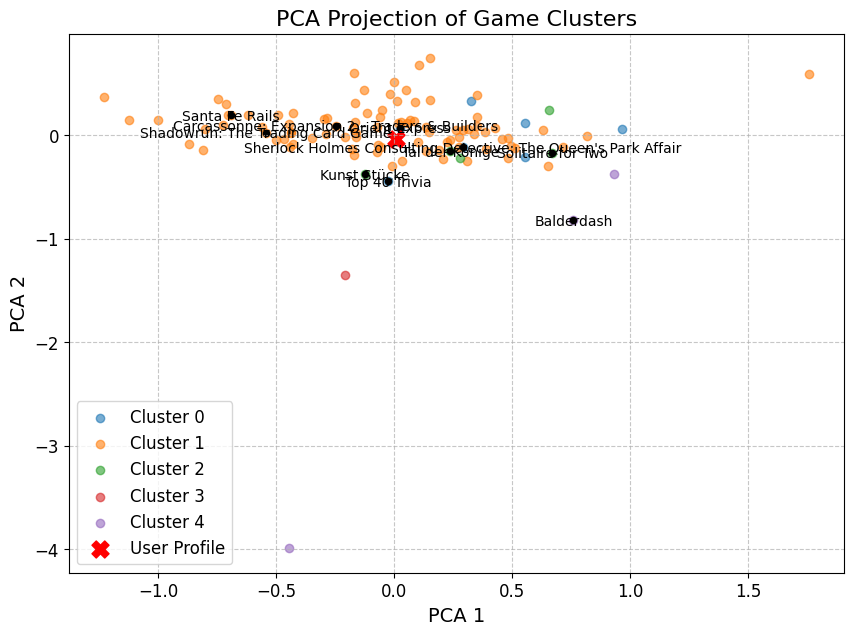

Recommended games for user 'Pyrogal'
                                                   name   rating    id  \
3                                        Tal der Könige  6.61540     4   
106                                          Balderdash  6.47848   163   
569                                        Kunst Stücke  6.38444   910   
1215                   Shadowrun: The Trading Card Game  6.46493  2123   
1403                                     Orient Express  6.68539  2363   
1540                                  Solitaire for Two  6.67939  2602   
1970  Sherlock Holmes Consulting Detective: The Quee...  7.52707  3225   
2059                                     Santa Fe Rails  6.79856  3348   
3250                                      Top 40 Trivia  6.50000  4929   
3634      Carcassonne: Expansion 2 – Traders & Builders  7.61864  5405   

      similarity                                        explanation  
3       0.926815  I recommend this game because you liked 'Empir...  
106     

In [53]:
user_name = "Pyrogal"
recommendations = recommend_content_based_cluster(
    user_name,
    games,
    filtered_reviews,
    max_playingtime=60,
    min_age=12,
    minplayers=2,
    maxplayers=4,
    min_rating=6,
    plot = True)
print(f"Recommended games for user '{user_name}'")
print(recommendations)

In [54]:
if recommendations is not None:
    for idx, row in recommendations.iterrows():
        print(f"{row['name']} (Rating: {row['rating']:.2f})")
        print(f"Similarity: {row['similarity']:.2f}")
        print(f"{row['explanation']}\n")

Tal der Könige (Rating: 6.62)
Similarity: 0.93
I recommend this game because you liked 'Empire Builder' (you rated it 7.0/10). This game has a 'dark' feeling and is 'competitive'.

Balderdash (Rating: 6.48)
Similarity: 0.92
I recommend this game because you liked 'RoboRally' (you rated it 6.0/10). This game has a 'serious' feeling and is 'strategic'.

Kunst Stücke (Rating: 6.38)
Similarity: 0.92
I recommend this game because you liked 'Carcassonne' (you rated it 8.0/10). This game has a 'nostalgic' feeling and is 'competitive'.

Shadowrun: The Trading Card Game (Rating: 6.46)
Similarity: 0.83
I recommend this game because you liked 'RoboRally' (you rated it 6.0/10). This game has a 'intense' feeling and is 'educational'.

Orient Express (Rating: 6.69)
Similarity: 0.82
I recommend this game because you liked 'Hungry' (you rated it 6.0/10). This game has a 'intense' feeling and is 'strategic'.

Solitaire for Two (Rating: 6.68)
Similarity: 0.82
I recommend this game because you liked 'Rob

##### Diversity-based RecSys comparison

Now we need to evaluate and compare the performance of the three content-based recommendation strategies introduced earlier.

The goal is to assess how each method balances accuracy and diversity in the recommendations.

We will be using precision and recall at top-k as evaluation metrics, both for an individual user and averaged across multiple users. This allows us to quantify how well each system recovers games the user actually liked, and observe the trade-offs between relevance and variety.

In [55]:
reviews[(reviews["user"] == 'jbuergel') & (reviews["rating"] >= 6)]

Unnamed: 0      user  rating  \
113425      1133921  jbuergel     7.0   
136479      1364711  jbuergel     7.0   
321767      3019297  jbuergel     9.0   
395539      3757155  jbuergel     6.0   
526672      5402389  jbuergel     9.0   
...             ...       ...     ...   
1799395    24000620  jbuergel     8.0   
1807722    24202310  jbuergel     6.0   
1847360    25159137  jbuergel     7.0   
1853580    25366977  jbuergel     6.0   
1861023    25616134  jbuergel     6.0   

                                                   comment   ID  \
113425   A landmark game for me, as it opened the door ...   13   
136479   Pleasant enough, but I don't love it.  I'm not...  822   
321767   A personal inspiration, Uwe Rosenberg here loo...   11   
395539   Another Rummy-style game, the shine came off o...   50   
526672    A pure auction game, this is outstanding filler.  172   
...                                                    ...  ...   
1799395  Phil Eklund always manages to pack a ton of at...  639   
1807722  In a world where I get to play against people ...  711   
1847360  A number of clever bits, and the theme is inte...  956   
1853580  Why do most zombie games suck?  This is at lea...  752   
1861023  This is a fun blind bidding game that is let d...  294   

                       name  
113425                CATAN  
136479          Carcassonne  
321767             Bohnanza  
395539          Lost Cities  
526672             For Sale  
...                     ...  
1799395  American Megafauna  
1807722          Elfenroads  
1847360              Azteca  
1853580     Maul of America  
1861023              Keydom  

[109 rows x 6 columns]

In [56]:
def get_highly_rated_games(reviews_df, user_name, rating_threshold=6):
    user_reviews = reviews_df[(reviews_df["user"] == user_name) & (reviews_df["rating"] >= rating_threshold)]
    return user_reviews

def precision_recall_manual(user_name, recommendations, highly_rated_games, k=10, threshold=6.0):
    relevant_ids = highly_rated_games["ID"].unique()  # All games the user rated highly

    # Top-k recommended game IDs
    rec_ids = recommendations["id"].head(k).values if not recommendations.empty else []

    # True positives
    hits = len(set(rec_ids) & set(relevant_ids))

    precision = hits / len(rec_ids) if len(rec_ids) > 0 else 0
    recall = hits / len(relevant_ids) if len(relevant_ids) > 0 else 0
    return precision, recall

We generate recommendations for a user using each of the three methods, applying the same filtering preferences.

In [57]:
user1 = "jbuergel"
highly_rated_games_user1 = get_highly_rated_games(filtered_reviews, user1, rating_threshold=6)

In [58]:
recs_basic = recommend_content_based_basic(
    user1, games, highly_rated_games_user1, testing = True, max_playingtime=60, min_age=12, minplayers=2, maxplayers=4)

recs_mmr = recommend_content_based_mmr(
    user1, games, highly_rated_games_user1, testing = True,  max_playingtime=60, min_age=12, minplayers=2, maxplayers=4)

recs_cluster = recommend_content_based_cluster(
    user1, games, highly_rated_games_user1, testing = True, max_playingtime=60, min_age=12, minplayers=2, maxplayers=4)

In [59]:
precision_basic, recall_basic = precision_recall_manual(
    user1, recs_basic, highly_rated_games_user1, k=5, threshold=6.0)
precision_mmr, recall_mmr = precision_recall_manual(
    user1, recs_mmr, highly_rated_games_user1, k=5, threshold=6.0)
precision_cluster, recall_cluster = precision_recall_manual(
    user1, recs_cluster, highly_rated_games_user1, k=5, threshold=6.0)

print(f"Precision@5 Basic: {precision_basic:.4f}")
print(f"Recall@5 Basic: {recall_basic:.4f}")

print(f"\nPrecision@5 MMR: {precision_mmr:.4f}")
print(f"Recall@5M MRR: {recall_mmr:.4f}")

print(f"\nPrecision@5 Cluster: {precision_cluster:.4f}")
print(f"Recall@5 Cluster: {recall_cluster:.4f}")

Precision@5 Basic: 0.0000
Recall@5 Basic: 0.0000

Precision@5 MMR: 0.4000
Recall@5M MRR: 0.0183

Precision@5 Cluster: 0.0000
Recall@5 Cluster: 0.0000


Precision@10 measures out of the 10 items recommended, how many were actually relevant. Recall@10 says out of all the relevant items for a user, how many did we manage to include in the top 10 recommendations. We can observe the MMR method is the best

Now we defined a general evaluation function to assess how each method performs across multiple users, not just one.

In [60]:
def evaluate_multiple_users(reviews_df, games_df, recommend_funcs, k=5, n_users=30, rating_threshold=6.0):
    """
    Evaluate average precision and recall over multiple users who have rated at least one game above the threshold.
    """
    users = reviews_df["user"].unique()
    random.shuffle(users)  # shuffle for randomness

    results = {method: {"precision": [], "recall": []} for method in recommend_funcs.keys()}
    evaluated_users = 0

    for user in users:
        highly_rated = get_highly_rated_games(reviews_df, user, rating_threshold)

        if highly_rated.empty:
            continue  # skip users with no high ratings

        for method_name, func in recommend_funcs.items():
            recs = func(user, games_df, highly_rated, testing=True,
                        max_playingtime=60, min_age=12, minplayers=2, maxplayers=4)

            precision, recall = precision_recall_manual(user, recs, highly_rated, k=k, threshold=rating_threshold)
            results[method_name]["precision"].append(precision)
            results[method_name]["recall"].append(recall)

        evaluated_users += 1
        if evaluated_users >= n_users:
            break  # stop once we have enough valid users

    # Compute average metrics
    avg_results = {}
    for method, metrics in results.items():
        avg_precision = sum(metrics["precision"]) / len(metrics["precision"]) if metrics["precision"] else 0
        avg_recall = sum(metrics["recall"]) / len(metrics["recall"]) if metrics["recall"] else 0
        avg_results[method] = {"avg_precision": avg_precision, "avg_recall": avg_recall}

    return avg_results

In [61]:
recommend_funcs = {
    "basic": recommend_content_based_basic,
    "mmr": recommend_content_based_mmr,
    "cluster": recommend_content_based_cluster
}

avg_metrics = evaluate_multiple_users(
    filtered_reviews, games,
    recommend_funcs=recommend_funcs,
    k=5, n_users=40, rating_threshold=6.0
)

for method, metrics in avg_metrics.items():
    print(f"{method.upper()} - Avg Precision@5: {metrics['avg_precision']:.4f}, Avg Recall@5: {metrics['avg_recall']:.4f}")

BASIC - Avg Precision@5: 0.0300, Avg Recall@5: 0.0536
MMR - Avg Precision@5: 0.0550, Avg Recall@5: 0.0565
CLUSTER - Avg Precision@5: 0.0350, Avg Recall@5: 0.0539


We can conclude the MMR recommender system is the best of the three

##### Hybrid content-based recommender system

Now we will try a hybrid recommender system, which is called hybrid because it comines elements from collaborative filtering and content-based filtering.

The content-based part is achieved using the GloVe vectors to represent each game, and the collaborative by using user rating behavior.

Note we only take the k most similar games. This is done in order to prevent bias towards the weighted mean of the user ratings. When a user has many rated games, the prediction of any of the rest of target games will converge to a number very close to the mean.

In [62]:
def predict_rating(user_name, target_game_id, games_df, reviews_df, k=10):
    # Get user-rated games
    user_reviews = reviews_df[(reviews_df["user"] == user_name)]

    if user_reviews.empty:
        return "No reviews found for this user."

    # Merge with games to get GloVe vectors
    user_games = user_reviews.merge(games_df[["id", "glove_vector"]], left_on="ID", right_on="id")

    if user_games.empty:
        return "User has rated games with no vector information."

    # Get vector of target game
    try:
        target_vector = games_df.loc[games_df["id"] == target_game_id, "glove_vector"].values[0]
    except IndexError:
        return "Target game ID not found in games dataset."

    # Compute cosine similarities
    rated_vectors = np.vstack(user_games["glove_vector"])
    similarities = cosine_similarity(rated_vectors, [target_vector]).flatten()
    similarities = np.maximum(similarities, 0)  # Ensure no negatives

    ratings = user_games["rating"].values

    # Get indices of top-k similar games
    if len(similarities) < k:
        k = len(similarities)
    top_k_idx = np.argsort(similarities)[-k:]

    top_similarities = similarities[top_k_idx]
    top_ratings = ratings[top_k_idx]

    if top_similarities.sum() == 0:
        return "No sufficiently similar games found."

    # Weighted average using top-k
    predicted_rating = np.average(top_ratings, weights=top_similarities)

    return round(predicted_rating, 2)

In [63]:
def predict_rating_with_explanation(user_name, target_game_id, games_df, reviews_df, k=10):
    user_reviews = reviews_df[reviews_df["user"] == user_name]
    if user_reviews.empty:
        return None, "No reviews found for this user."

    user_games = user_reviews.merge(games_df[["id", "glove_vector", "name"]], left_on="ID", right_on="id")
    if user_games.empty:
        return None, "User has rated games with no vector information."
    try:
        target_vector = games_df.loc[games_df["id"] == target_game_id, "glove_vector"].values[0]
    except IndexError:
        return None, "Target game ID not found in games dataset."

    rated_vectors = np.vstack(user_games["glove_vector"])
    similarities = cosine_similarity(rated_vectors, [target_vector]).flatten()
    similarities = np.maximum(similarities, 0)

    ratings = user_games["rating"].values

    if len(similarities) < k:
        k = len(similarities)
    top_k_idx = np.argsort(similarities)[-k:]

    top_similarities = similarities[top_k_idx]
    top_ratings = ratings[top_k_idx]
    top_game_names = user_games.iloc[top_k_idx]["name_y"].tolist()

    if top_similarities.sum() == 0:
        return None, "No sufficiently similar games found."

    predicted_rating = round(np.average(top_ratings, weights=top_similarities), 2)

    # Build explanation
    if len(top_game_names) == 1:
        explanation = f"Because you liked **{top_game_names[0]}**, and this game is similar to it."
    elif len(top_game_names) == 2:
        explanation = f"Because you liked **{top_game_names[0]}** and **{top_game_names[1]}**, and this game is similar to both."
    else:
        explanation = f"Because you liked games like **{top_game_names[0]}**, **{top_game_names[1]}**, and others."

    return predicted_rating, explanation

The next code is to check range of predictions in all target games

In [64]:
def predict_all_ratings(user_name, games_df, reviews_df, k=10):
    # Get user-rated games and their vectors
    user_reviews = reviews_df[reviews_df["user"] == user_name]
    if user_reviews.empty:
        return "No reviews found for this user."

    user_games = user_reviews.merge(games_df[["id", "glove_vector"]], left_on="ID", right_on="id")
    if user_games.empty:
        return "User has rated games with no vector information."

    rated_vectors = np.vstack(user_games["glove_vector"])
    rated_ratings = user_games["rating"].values
    rated_names = user_games["name"].tolist()

    # Games not yet rated by user
    unseen_games = games_df[~games_df["id"].isin(user_games["id"])].copy()
    if unseen_games.empty:
        return "No unseen games to predict ratings for."

    predicted_ratings = []

    for _, game in unseen_games.iterrows():
        target_vector = game["glove_vector"]

        # Cosine similarity with all user-rated games
        similarities = cosine_similarity(rated_vectors, [target_vector]).flatten()
        similarities = np.maximum(similarities, 0)

        # Select top-k most similar games
        if len(similarities) < k:
            k_adj = len(similarities)
        else:
            k_adj = k

        top_k_idx = np.argsort(similarities)[-k_adj:]
        top_similarities = similarities[top_k_idx]
        top_ratings = rated_ratings[top_k_idx]
        top_game_names = [rated_names[i] for i in top_k_idx]

        if top_similarities.sum() == 0:
            pred_rating = np.nan
            explanation = "No sufficiently similar games found."
        else:
            pred_rating = np.average(top_ratings, weights=top_similarities)
            # Build explanation
            if len(top_game_names) == 1:
                explanation = f"Because you liked **{top_game_names[0]}**, and this game is similar to it."
            elif len(top_game_names) == 2:
                explanation = f"Because you liked **{top_game_names[0]}** and **{top_game_names[1]}**, and this game is similar to both."
            else:
                explanation = f"Because you liked games like **{top_game_names[0]}**, **{top_game_names[1]}**, and others."

        predicted_ratings.append((game["id"], game["name"], round(pred_rating, 2) if not np.isnan(pred_rating) else None, explanation))

    # Return as a DataFrame
    pred_df = pd.DataFrame(predicted_ratings, columns=["id", "name", "predicted_rating", "explanation"])
    pred_df = pred_df.sort_values(by="predicted_rating", ascending=False)

    return pred_df

In [65]:
predictions_df = predict_all_ratings("jbuergel", games, reviews, k=10)
predictions_df

id                                    name  predicted_rating  \
3927  5975               Monster Maker 7: Prophecy              8.19   
2285  3871                               Factories              8.10   
2269  3850                        Galactic Empires              8.10   
1931  3394                  Monopoly: The Simpsons              8.10   
267    603                                  Putsch              8.01   
...    ...                                     ...               ...   
440    907                                Beheaded              4.50   
3189  5104                          Yogi Bear Game              4.49   
3258  5180  Murder à la carte: What the Butler Saw              4.41   
994   2016                         The Gothic Game              4.30   
3539  5494                           Talkin' Tango              4.20   

                                            explanation  
3927  Because you liked games like **Warhammer Quest...  
2285  Because you liked games like **Bohnanza**, **B...  
2269  Because you liked games like **Battle Hymn**, ...  
1931  Because you liked games like **Sleuth**, **Los...  
267   Because you liked games like **Age of Renaissa...  
...                                                 ...  
440   Because you liked games like **Mystery of the ...  
3189  Because you liked games like **Wyatt Earp**, *...  
3258  Because you liked games like **Dino Hunt**, **...  
994   Because you liked games like **Bitin' Off Hedz...  
3539  Because you liked games like **Before I Kill Y...  

[3952 rows x 4 columns]

It is important, however, to test different values of k (number of similar items considered), since this can affect the predictions:

*   A small k uses the most similar items, hence it is more personalized but probably noisier.
*   A large k uses more items, hence smoother predictions but more biased towards the average.

In [66]:
def split_reviews_for_user(reviews_df, user_name, test_size=0.3, random_state=42):
    user_reviews = reviews_df[reviews_df["user"] == user_name]

    if user_reviews.empty:
        raise ValueError(f"No reviews found for user {user_name}")

    # Split the reviews into train and test
    train_reviews, test_reviews = train_test_split(user_reviews, test_size=test_size, random_state=random_state)

    return train_reviews, test_reviews

In [67]:
def predict_all_ratings_k_values_with_rmse(user_name, games_df, reviews_df, test_df, k_values=[5, 10]):
    results = {}

    # Prepare user data
    user_train = reviews_df[reviews_df["user"] == user_name]
    test_data = test_df[test_df["user"] == user_name]

    if user_train.empty or test_data.empty:
        return "Not enough data for user"

    user_games = user_train.merge(games_df[["id", "glove_vector"]], left_on="ID", right_on="id")
    rated_vectors = np.vstack(user_games["glove_vector"])
    rated_ratings = user_games["rating"].values

    for k in k_values:
        predicted = []
        actual = []

        for _, game in test_data.iterrows():
            game_id = game["ID"]
            true_rating = game["rating"]
            try:
                target_vector = games_df.loc[games_df["id"] == game_id, "glove_vector"].values[0]
            except IndexError:
                continue

            sims = cosine_similarity(rated_vectors, [target_vector]).flatten()
            sims = np.maximum(sims, 0)
            top_k_idx = np.argsort(sims)[-k:]
            top_sims = sims[top_k_idx]
            top_ratings = rated_ratings[top_k_idx]

            if top_sims.sum() == 0:
                continue

            pred_rating = np.average(top_ratings, weights=top_sims)
            predicted.append(pred_rating)
            actual.append(true_rating)

        if predicted:
            rmse = sqrt(mean_squared_error(actual, predicted))
            results[k] = rmse

    return results

In [71]:
# We import this train test split here to not mistake it with the one from surprise library
from sklearn.model_selection import train_test_split

user = "jbuergel"
train_df, test_df = split_reviews_for_user(reviews, user)

rmse_by_k = predict_all_ratings_k_values_with_rmse(
    user_name=user,
    games_df=games,
    reviews_df=train_df,   # this is used for building the user profile
    test_df=test_df,       # this is used for evaluating predictions
    k_values=[3, 5, 10, 15, 20, 30, 40, 50]
)
rmse_by_k

{3: 2.339699756971148,
 5: 2.1345082266647206,
 10: 2.090568898297073,
 15: 2.020948473580571,
 20: 2.052274409501617,
 30: 2.090248606491099,
 40: 2.074656624819229,
 50: 2.0736012457866715}

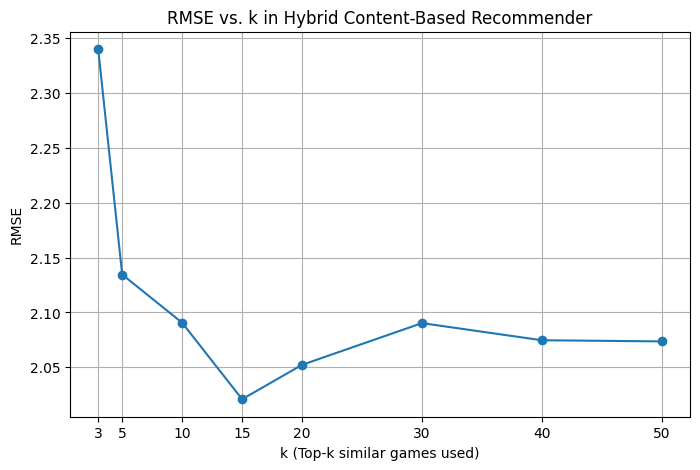

In [72]:
ks = list(rmse_by_k.keys())
rmse_values = list(rmse_by_k.values())

plt.figure(figsize=(8, 5))
plt.plot(ks, rmse_values, marker='o')
plt.title("RMSE vs. k in Hybrid Content-Based Recommender")
plt.xlabel("k (Top-k similar games used)")
plt.ylabel("RMSE")
plt.grid(True)
plt.xticks(ks)
plt.show()

In [73]:
predictions_df = predict_rating("jbuergel", 13, games, reviews, k=10)
predictions_df

5.72

In [74]:
predicted_score, explanation = predict_rating_with_explanation("jbuergel", 13, games, reviews, k=10)
if predicted_score is not None:
    print(f"You’d probably rate this game {predicted_score}/10")
    print(explanation)
else:
    print(explanation)

You’d probably rate this game 5.72/10
Because you liked games like **Age of Renaissance**, **Bandu**, and others.


##### Cold Start for Hybrid RecSys

For this project, it is important to highlight that we considered the so-called 'cold-start' scenarios. Cold-start refers to when a user does not have ratings at all or only a few, which makes collaborative or hybrid recommendations unreliable.

Our original hybrid system depends on having enough rated games to compare against, so it doesn't work well when this data is missing.

Because of this, we offer two approaches:

*   Allow users to manually select a few games they like (simulating initial ratings).
*   Recommend games based on popularity and clustering, ensuring relevance and diversity.


**OPTION 1: Cold start with user choosing three games**

In [75]:
# Simulate cold start user
cold_start_user = "new_user"

# Let’s pretend they selected these game IDs as their favorites
liked_game_ids = [12, 91, 170]  # These must exist in games["id"]

# Create a pseudo-review dataframe for them
cold_reviews = pd.DataFrame({
    "user": [cold_start_user] * len(liked_game_ids),
    "ID": liked_game_ids,
    "rating": [9] * len(liked_game_ids)  # simulate high preference
})

# Run the recommender with this pseudo-profile
cold_recs = recommend_content_based_mmr(
    user_name=cold_start_user,
    games=games,
    reviews=cold_reviews,
    top_k=10,
    max_playingtime=60,
    min_age=12,
    minplayers=2,
    maxplayers=4,
    min_rating=6
)

print(cold_recs)

                                                   name   rating    id  \
432                                       Minion Hunter  6.21185   679   
506                                             Keytown  6.48465   768   
1215                   Shadowrun: The Trading Card Game  6.46493  2123   
1220                                               Rage  6.12190  2133   
1302  Zero!: The Rise and Fall of The Imperial Japan...  6.95177  2247   
1615                                           Suzerain  6.00290  2716   
2000                                          Holocaust  6.50000  3286   
2059                                     Santa Fe Rails  6.79856  3348   
3889                                        Squad Seven  6.41135  5711   
3904                                            Domaine  6.98587  5737   

      similarity                                        explanation  
432     0.943066  I recommend this game because you liked 'Paths...  
506     0.939007  I recommend this game becau

**OPTION 2: Cold start with popularity-based recommnender**

Before implementing the recommender, we explored two things:

1.   Choosing the number of clusters using the Elbow method.
2.   Visualizing the game space with t-SNE to confirm meaningful clustering.



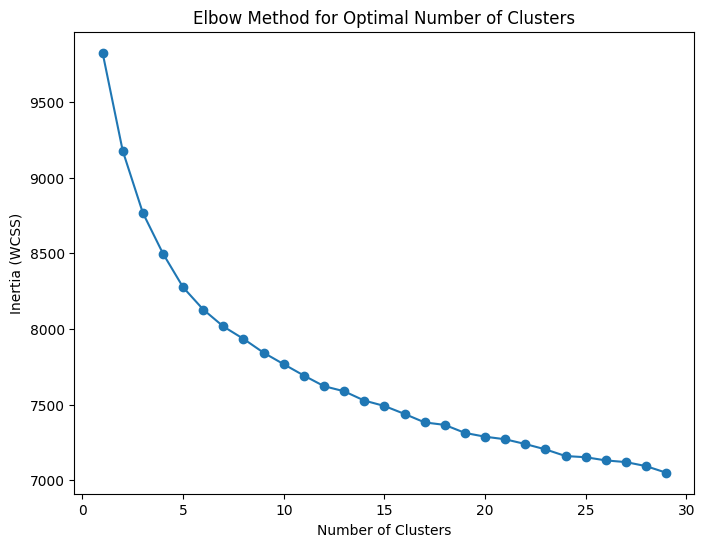

In [76]:
# Calculate the inertia (WCSS) for different values of k
inertia = []
k_range = range(1, 30)  # Try different cluster counts

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(np.vstack(games["glove_vector"]))
    inertia.append(kmeans.inertia_)

# Plot the inertia values
plt.figure(figsize=(8, 6))
plt.plot(k_range, inertia, marker="o")
plt.title("Elbow Method for Optimal Number of Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia (WCSS)")
plt.show()

In [77]:
n_clusters = 20
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
games["description_cluster"] = kmeans.fit_predict(np.vstack(games["glove_vector"]))

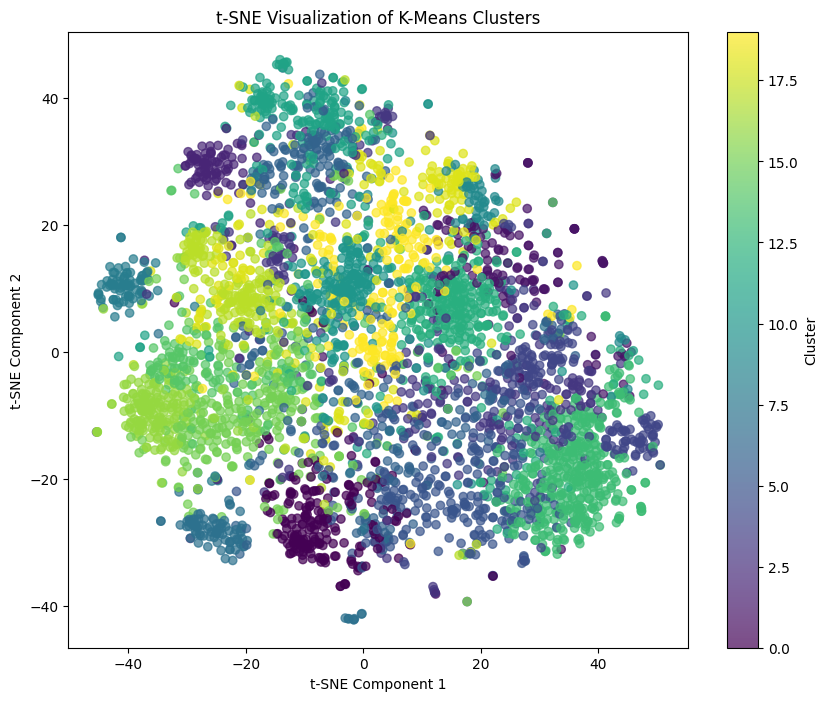

In [78]:
# Get the embeddings (glove vectors) from the 'glove_vector' column
embeddings = np.vstack(games["glove_vector"])

# Perform t-SNE to reduce dimensions to 2D
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(embeddings)

# Add t-SNE results to the games dataframe
games["tsne_1"] = tsne_results[:, 0]
games["tsne_2"] = tsne_results[:, 1]

# Plot t-SNE representation with cluster labels
plt.figure(figsize=(10, 8))
plt.scatter(games["tsne_1"], games["tsne_2"], c=games["description_cluster"], cmap="viridis", alpha=0.7)
plt.colorbar(label="Cluster")
plt.title("t-SNE Visualization of K-Means Clusters")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.show()

In [79]:
# Compute average ratings and number of ratings per game
ratings = filtered_reviews.groupby("ID")["rating"].agg(["mean", "count"]).reset_index()
ratings.columns = ["id", "avg_rating", "num_ratings"]

# Compute popularity score: weighted average of rating and the number of ratings
ratings["popularity_score"] = (ratings["avg_rating"] * ratings["num_ratings"]) / (ratings["num_ratings"] + 10)

# Merge popularity scores with the games DataFrame and add suffixes to avoid column name conflicts
games = games.merge(ratings, left_on="id", right_on="id", how="left", suffixes=('', '_ratings'))

In [80]:
def get_diverse_popular_games(games, top_k=10):
    recommended_games = []

    # Iterate over clusters to get popular games from each cluster
    for cluster in range(games["description_cluster"].nunique()):
        # Get games in the cluster
        games_cluster = games[games["description_cluster"] == cluster]

        # Sort by popularity
        games_cluster = games_cluster.sort_values("popularity_score", ascending=False)

        # Select the top 1 game from each cluster to ensure diversity
        top_game = games_cluster.head(1)
        recommended_games.append(top_game)

    # Combine all recommended games and sort by popularity score
    recommended_games = pd.concat(recommended_games)
    recommended_games = recommended_games.sort_values("popularity_score", ascending=False).head(top_k)

    explanations = []
    for _, row in recommended_games.iterrows():
        cluster = row["description_cluster"]
        rating = round(row["avg_rating"], 2)
        num = int(row["num_ratings"])

        explanation = (
            f"This game is highly rated ({rating}/10 from {num} users) "
            f"and was selected to represent a distinct style or theme (cluster {cluster})."
        )
        explanations.append(explanation)

    recommended_games["explanation"] = explanations

    return recommended_games[["name", "clean_description", "avg_rating", "num_ratings", "popularity_score", "explanation"]]

In [81]:
cold_recs = get_diverse_popular_games(games, top_k=10)
print(cold_recs)

                               name  \
74                   Paths of Glory   
174           Advanced Squad Leader   
1196        The Civil War 1861-1865   
129                              Go   
89                             Dune   
151                           Tichu   
593   Star Wars: The Queen's Gambit   
459      Blood Bowl (Third Edition)   
758                       Netrunner   
502                     Battle Line   

                                      clean_description  avg_rating  \
74    gmt website call great war year titanic strugg...    8.065980   
174   advanced squad leader completely reorganize de...    8.001090   
1196  sprawl rendition american civil war fit grant ...    7.725287   
129   appearance take lay stone time small grid inte...    7.652169   
89    thousand year future dune board base frank her...    7.587277   
151   tichu take mechanic zheng fen partnership clim...    7.571622   
593   base battle star war episode phantom menace ba...    7.590048   
45

#### Collaborative filtering

In this section, we implement collaborative filtering approaches using the Surprise library. These methods only rely on ratings, without needing content features. We explore both neighborhood-based and latent factor models.

##### Data filtering

We begin by filtering out users by randomly sample to reduce computational cost, and format the data to work with Surprise's rating-based datasets.



In [82]:
# Sample 10000 users to have less reviews
sampled_users = np.random.choice(reviews["user"].unique(), size=10000, replace=False)
sampled_reviews = reviews[reviews["user"].isin(sampled_users)]

In [83]:
reviews = sampled_reviews
reviews

Unnamed: 0        user  rating  \
13               13       Elyah    10.0   
21               21      turtle    10.0   
132             132      turtle    10.0   
150             150        Wald    10.0   
156             156    Greblord    10.0   
...             ...         ...     ...   
1872343    26191711     Pfluftl     3.0   
1872389    26198160  robertg611     6.0   
1872421    26199302  ThomasinNY     3.0   
1872431    26199312      strahd     1.0   
1872438    26199319    balsak40     1.0   

                                                   comment    ID  \
13                                                     NaN    13   
21       One of my all time favorite games. I usually o...    13   
132      Currently my favorite and most played game. Hi...   822   
150         The defining minimal German-style game for me.   822   
156                                             Brilliant.   822   
...                                                    ...   ...   
1872343                                                NaN  1914   
1872389  Great old game, one of the first games I ever ...  1624   
1872421                                                NaN  1546   
1872431                                                NaN  1546   
1872438                                 Awful, just awful.  1546   

                               name  
13                            CATAN  
21                            CATAN  
132                     Carcassonne  
150                     Carcassonne  
156                     Carcassonne  
...                             ...  
1872343                Im 7. Himmel  
1872389     Quest of the Magic Ring  
1872421  Worlds of Heroes & Tyrants  
1872431  Worlds of Heroes & Tyrants  
1872438  Worlds of Heroes & Tyrants  

[67691 rows x 6 columns]

We observe the users with the highest number of ratings

In [84]:
# Count number of ratings per user
top_users = reviews['user'].value_counts().head(10)

# Print
print("Top users by number of ratings:")
print(top_users)

Top users by number of ratings:
user
qzhdad               433
FC Dynamo Turbine    318
skeletodoc           242
DerSchroeder         238
Jürgen               238
Chris Sjoholm        210
Magic Rat            209
boomtron             203
chaddyboy_2000       184
pwotruba             182
Name: count, dtype: int64


As we are using the Surprise library, we need to build a special surprise dataset. Firstly, we define the range of ratings and provide three fields for the dataset: user, ID and rating.

In [85]:
# Load data
# Range of ratings
reader = Reader(rating_scale=(1, 10))

# Dataset Auto Folds only with user, game ID and rating.
data = Dataset.load_from_df(reviews[["user", "ID", "rating"]], reader)

After this, the data is split into train and test. The train set becomes a surprise dataset, while the test set is a simple python list.

In [86]:
# Importing this one here to not mistake it with the sklearn one
from surprise.model_selection import GridSearchCV, train_test_split

# Train-test split
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)
print(type(trainset))
print(type(testset))

<class 'surprise.trainset.Trainset'>
<class 'list'>


By printing some samples in the train sets we observe that the samples are composed by a user id, item id and rating. In order to work with this dataset, the IDs have been modified to relative IDs, not the original ones provided from the reviews dataset.

In [87]:
print(list(trainset.all_ratings())[:10])
# Note the relative user ids.

[(0, 0, 7.0), (0, 7, 7.0), (1, 1, 5.0), (1, 7, 8.0), (1, 173, 6.0), (1, 266, 6.0), (1, 129, 4.0), (1, 261, 5.0), (1, 226, 5.0), (1, 72, 4.0)]


In [88]:
testset[:10]

[('aleksi_ahtiainen', 215, 8.0),
 ('ironclaw', 11, 5.0),
 ('georgeschmitz', 50, 6.5),
 ('ThomasinNY', 60, 7.0),
 ('Ironleaves', 760, 6.0),
 ('tanookihero', 13, 5.0),
 ('leon_noel', 320, 10.0),
 ('pwotruba', 46, 8.0),
 ('Malcolm C', 755, 4.0),
 ('Beedersen', 354, 7.0)]

##### Neighborhood-based methods


We will begin by exploring KNN-based collaborative filtering, where the rating for a game is predicted based on similar users or items.

We will be hyperparamter tuning k (number of neighbors) and min_k (minimum number of neighbors) using RMSE as a performance metric. Grid search is then applied to test different similarity measures and models like KNNBasic and KNNWithMeans.

To narrow down the gridsearch, we can explore these hyperaparameters with the KNNBasic model to see where does the performance stabilizes. This will also help us to not consider a huge grid during gridsearch.

Trying k = 10
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.4847
Trying k = 20
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.4596
Trying k = 30
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.4511
Trying k = 40
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.4470
Trying k = 50
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.4451
Trying k = 60
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.4438
Trying k = 70
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.4434
Trying k = 80
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.4431
Trying k = 90
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.4427
Trying k = 100
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.4427

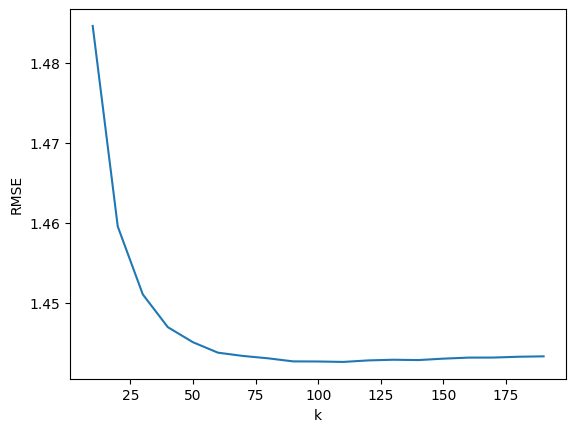

In [89]:
# Discovering the right value for k_max
range_K = range(10,200,10)
RMSE_K = []

for k in range_K:
    print(f"Trying k = {k}")
    algo = KNNBasic(k=k)
    algo.fit(trainset)
    predictions = algo.test(testset)
    RMSE_K.append(accuracy.rmse(predictions))

plt.plot(range_K, RMSE_K)
plt.xlabel('k')
plt.ylabel('RMSE')
plt.show()

With this plot, we observe that the optimal maximum k lays around 30-60. Values between these will be used in the grid search

The same procedure will be done with min_k, providing the optimal number of minimum neighbours

Trying min_k = 1
Computing the msd similarity matrix...
Done computing similarity matrix.
Trying min_k = 2
Computing the msd similarity matrix...
Done computing similarity matrix.
Trying min_k = 3
Computing the msd similarity matrix...
Done computing similarity matrix.
Trying min_k = 4
Computing the msd similarity matrix...
Done computing similarity matrix.
Trying min_k = 5
Computing the msd similarity matrix...
Done computing similarity matrix.
Trying min_k = 6
Computing the msd similarity matrix...
Done computing similarity matrix.
Trying min_k = 7
Computing the msd similarity matrix...
Done computing similarity matrix.
Trying min_k = 8
Computing the msd similarity matrix...
Done computing similarity matrix.
Trying min_k = 9
Computing the msd similarity matrix...
Done computing similarity matrix.
Trying min_k = 10
Computing the msd similarity matrix...
Done computing similarity matrix.
Trying min_k = 11
Computing the msd similarity matrix...
Done computing similarity matrix.
Trying m

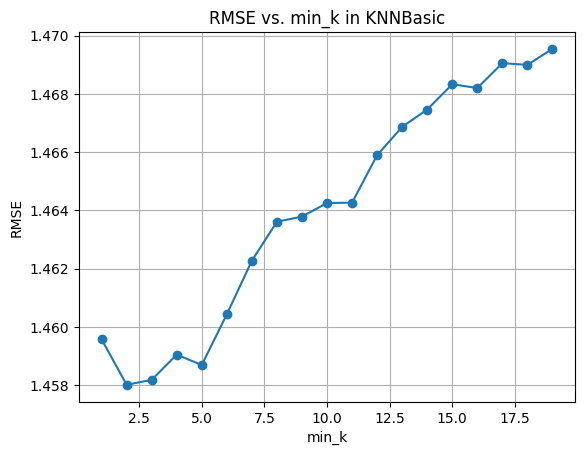

In [90]:
# Discovering the right value for min_k
range_minK = range(1, 20)
RMSE_minK = []

for mink in range_minK:
    print(f"Trying min_k = {mink}")
    algo = KNNBasic(k=20, min_k=mink)
    algo.fit(trainset)
    predictions = algo.test(testset)
    rmse = accuracy.rmse(predictions, verbose=False)
    RMSE_minK.append(rmse)

plt.plot(range_minK, RMSE_minK, marker='o')
plt.xlabel('min_k')
plt.ylabel('RMSE')
plt.title('RMSE vs. min_k in KNNBasic')
plt.grid(True)
plt.show()

As observed in the plot, the optimal number of minimum neighbors, which reduces the RMSE lays around 5.

Now let's finetune the parameters by using a grid search with the method implemented in the surprise library. In order to work with this method, the complete dataset must be provided to the grid search, not the separated train and test sets.

The similarities options we will test are 'cosine' (based on cosine similarity) and 'pearson' (based on pearson correlation).

For this project, only item-based approaches will be tested, and we will avoid user-based due to computational power and scope of the project.

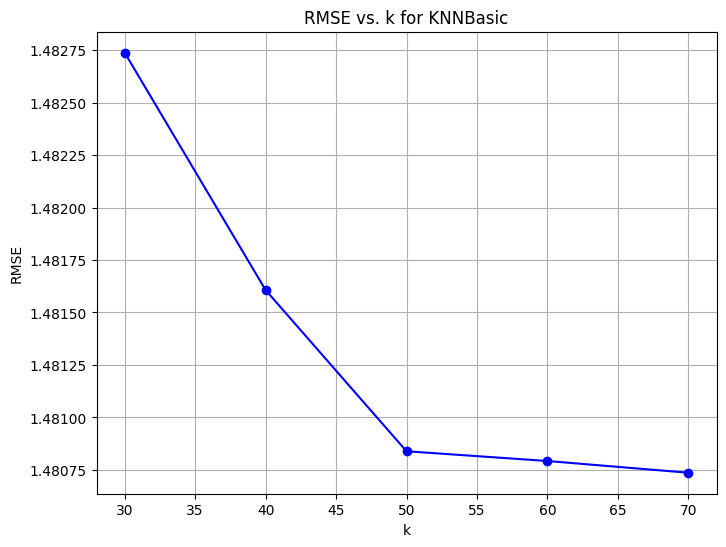

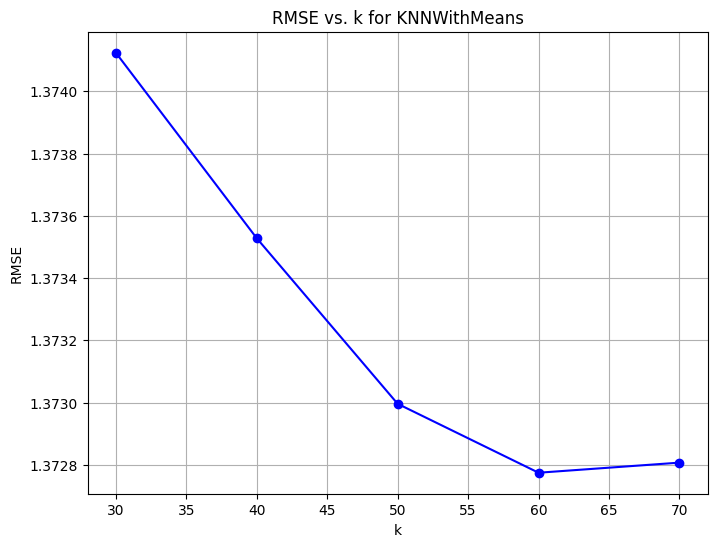

In [91]:

# Define parameters
param_grids = {
    'KNNBasic': {
        'k': [30, 40, 50, 60, 70],
        'min_k': [3, 6, 7],
        'sim_options': {
            'name': ['cosine', 'pearson'],
            'user_based': [False],
        }
    },
    'KNNWithMeans': {
        'k': [30, 40, 50, 60, 70],
        'min_k': [3, 6, 7],
        'sim_options': {
            'name': ['cosine', 'pearson'],
            'user_based': [False],
        }
    }
}

# Store results
results = []
best_models = {}  # To store the best model for each algorithm

# Loop through algorithms and perform grid search
for algo_name, param_grid in param_grids.items():
    algo_class = eval(algo_name)
    gs = GridSearchCV(algo_class, param_grid, measures=['rmse', 'mae'], cv=3, n_jobs=-1)
    gs.fit(data)  # Fit on the full dataset to find best parameters

    # Store the best model
    best_models[algo_name] = gs.best_estimator['rmse']

    # Store the result of the grid search
    results.append({
        'Algorithm': algo_name,
        'Best RMSE': gs.best_score['rmse'],
        'Best MAE': gs.best_score['mae'],
        'Best Params': gs.best_params['rmse']
    })

    # Plotting the best k values
    # Extract k values and corresponding RMSE scores
    k_values = param_grid['k']
    rmse_scores = []

    # Loop through each k value and find corresponding RMSE score
    for k in k_values:
        # Filter out the corresponding scores for each k value
        mask = [params['k'] == k for params in gs.cv_results['params']]
        k_rmse_scores = [gs.cv_results['mean_test_rmse'][i] for i in range(len(gs.cv_results['params'])) if mask[i]]
        rmse_scores.append(k_rmse_scores[0])  # Assuming only one score per k value

    plt.figure(figsize=(8, 6))
    plt.plot(k_values, rmse_scores, marker='o', linestyle='-', color='b')
    plt.title(f'RMSE vs. k for {algo_name}')
    plt.xlabel('k')
    plt.ylabel('RMSE')
    plt.grid(True)
    plt.show()

In [92]:
# Show results of the grid search
results_df = pd.DataFrame(results)
results_df

Algorithm  Best RMSE  Best MAE  \
0      KNNBasic   1.480737  1.125123   
1  KNNWithMeans   1.372775  1.034029   

                                         Best Params  
0  {'k': 70, 'min_k': 3, 'sim_options': {'name': ...  
1  {'k': 60, 'min_k': 3, 'sim_options': {'name': ...

In [93]:
for index, row in results_df.iterrows():
    print(f"Algorithm: {row['Algorithm']}")
    print(f"Best Params: {row['Best Params']}")
    print("-" * 20)

Algorithm: KNNBasic
Best Params: {'k': 70, 'min_k': 3, 'sim_options': {'name': 'cosine', 'user_based': False}}
--------------------
Algorithm: KNNWithMeans
Best Params: {'k': 60, 'min_k': 3, 'sim_options': {'name': 'cosine', 'user_based': False}}
--------------------


In [94]:
# Choose the best algorithm based on the best RMSE from the grid search
best_algorithm_name = results_df.loc[results_df['Best RMSE'].idxmin()]['Algorithm']
best_model = best_models[best_algorithm_name]
print(f"Using the best model: {best_algorithm_name} with parameters: {results_df.loc[results_df['Best RMSE'].idxmin()]['Best Params']}")

Using the best model: KNNWithMeans with parameters: {'k': 60, 'min_k': 3, 'sim_options': {'name': 'cosine', 'user_based': False}}


Once we have found the best model, we can test its ability to recommend games to a specific user.

In [95]:
best_model = KNNWithMeans(k=50, min_k=5, sim_options={'name': 'cosine', 'user_based': False})
best_model.fit(trainset)

# Save KNNWithMeans model
with open("knn_model.pkl", "wb") as f:
    pickle.dump(best_model, f)

user = 'jbourgel'

# Games the user has already rated
rated_game_ids = reviews[reviews["user"] == user]["ID"].unique()

# All possible game IDs
all_game_ids = games["id"].unique()

# Filter out the ones already rated
unseen_game_ids = [gid for gid in all_game_ids if gid not in rated_game_ids]

# Predict ratings for the unseen games
predictions_user = [(gid, best_model.predict(user, gid).est) for gid in unseen_game_ids]

# Sort by predicted rating
top_k = 10
top_predictions = sorted(predictions_user, key=lambda x: x[1], reverse=True)[:top_k]

# Get game info from the original games DataFrame
top_game_ids = [pred[0] for pred in top_predictions]
recommended_games = games[games["id"].isin(top_game_ids)][["id", "name", "rating"]]

print("\nTop Recommended Games:")
print(recommended_games.reset_index(drop=True))

Computing the cosine similarity matrix...
Done computing similarity matrix.

Top Recommended Games:
   id                name   rating
0   1          Die Macher  7.58777
1   2        Dragonmaster  6.66468
2   3             Samurai  7.47596
3   4      Tal der Könige  6.61540
4   5             Acquire  7.35053
5   6  Mare Mediterraneum  6.45230
6   7           Cathedral  6.54958
7   8   Lords of Creation  6.05322
8   9        El Caballero  6.46943
9  10           Elfenland  6.67221


In [96]:
# Get predictions on test set
predictions = best_model.test(testset)

# Calculate performance metrics
print("Evaluation Metrics:")
rmse = accuracy.rmse(predictions)
mae = accuracy.mae(predictions)

Evaluation Metrics:
RMSE: 1.3758
MAE:  1.0350


In [97]:
# Precision@K and Recall@K (k = 10 by default)
def precision_recall_at_k(predictions, k=10, threshold=7.0):
    # Map user to list of (item_id, true_rating, est_rating)
    # Here we group predictions by user
    user_est_true = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        user_est_true[uid].append((iid, true_r, est))

    precisions = dict()
    recalls = dict()

    # For each user we simulate getting their top-k recommendations:
    for uid, user_ratings in user_est_true.items():
        # Sort by estimated rating
        user_ratings.sort(key=lambda x: x[2], reverse=True)
        top_k = user_ratings[:k]

        # How many relevant items are in the test set? (true_rating ≥ 8)
        n_rel = sum((true_r >= threshold) for (_, true_r, _) in user_ratings)

        # How many of the top-k recommended items are estimated to be ≥ 8?
        n_rec_k = sum((est >= threshold) for (_, _, est) in top_k)

        # How many are both relevant and recommended?
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold)) for (_, true_r, est) in top_k)

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    # Average over all users
    avg_precision = sum(precisions.values()) / len(precisions)
    avg_recall = sum(recalls.values()) / len(recalls)
    return avg_precision, avg_recall

In [98]:
precision, recall = precision_recall_at_k(predictions, k=10)
print(f"Precision@10: {precision:.4f}")
print(f"Recall@10: {recall:.4f}")

Precision@10: 0.4585
Recall@10: 0.4333


As we saw before, the precision@10 measures out of the 10 items recommended, how many were actually relevant. Recall@10 says out of all the relevant items for a user, how many did we manage to include in the top 10 recommendations

##### Latent based methods

Before ending this section of collaborative filtering, we also wanted to test latent factor models. These try to compress user and item interactions into a smaller set of hidden features.

These methods try to uncover the underlying structure in rating data, capturing things like genre preference, complexity tolerance, or thematic interests.

We test two models from the Surprise library:

*   SVD (Singular Value Decomposition): Learns latent factors via matrix factorization using gradient descent.
*   NMF (Non-negative Matrix Factorization): Learns additive latent components, and it is often more interpretable.

Value of nlatents: 1
RMSE: 1.6156
Value of nlatents: 6
RMSE: 1.5594
Value of nlatents: 11
RMSE: 1.5437
Value of nlatents: 16
RMSE: 1.5561
Value of nlatents: 21
RMSE: 1.5635
Value of nlatents: 26
RMSE: 1.5664
Value of nlatents: 31
RMSE: 1.5742
Value of nlatents: 36
RMSE: 1.5780
Value of nlatents: 41
RMSE: 1.5754
Value of nlatents: 46
RMSE: 1.5869
Value of nlatents: 51
RMSE: 1.5913
Value of nlatents: 56
RMSE: 1.5944
Value of nlatents: 61
RMSE: 1.5953
Value of nlatents: 66
RMSE: 1.6026
Value of nlatents: 71
RMSE: 1.6055
Value of nlatents: 76
RMSE: 1.6167
Value of nlatents: 81
RMSE: 1.6139
Value of nlatents: 86
RMSE: 1.6218
Value of nlatents: 91
RMSE: 1.6233
Value of nlatents: 96
RMSE: 1.6382
Value of nlatents: 101
RMSE: 1.6333
Value of nlatents: 106
RMSE: 1.6367
Value of nlatents: 111
RMSE: 1.6511
Value of nlatents: 116
RMSE: 1.6466
Value of nlatents: 121
RMSE: 1.6573
Value of nlatents: 126
RMSE: 1.6640
Value of nlatents: 131
RMSE: 1.6629
Value of nlatents: 136
RMSE: 1.6549
Value of nlate

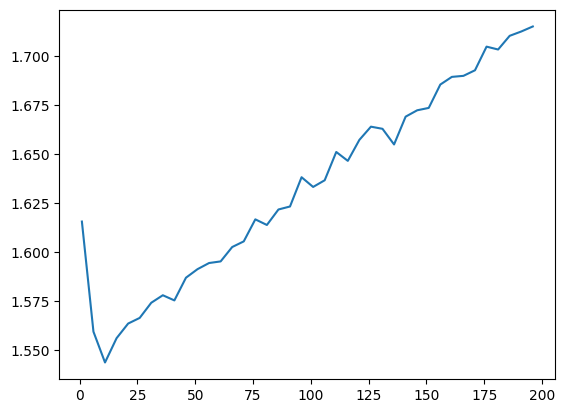

In [99]:
range_nlatents =  range(1,200, 5)
RMSE_nlatents = []
for nlatents in range_nlatents:
  print('Value of nlatents: ' + str(nlatents))
  algoLatent = SVD(n_factors = nlatents, biased = False)
  algoLatent.fit(trainset)
  predictions = algoLatent.test(testset)
  RMSE_nlatents.append(accuracy.rmse(predictions))

plt.figure()
plt.plot(range_nlatents, RMSE_nlatents)

Value of nlatents: 1
RMSE: 1.3395
Value of nlatents: 6
RMSE: 1.3453
Value of nlatents: 11
RMSE: 1.3522
Value of nlatents: 16
RMSE: 1.3466
Value of nlatents: 21
RMSE: 1.3570
Value of nlatents: 26
RMSE: 1.3548
Value of nlatents: 31
RMSE: 1.3533
Value of nlatents: 36
RMSE: 1.3583
Value of nlatents: 41
RMSE: 1.3588
Value of nlatents: 46
RMSE: 1.3597
Value of nlatents: 51
RMSE: 1.3540
Value of nlatents: 56
RMSE: 1.3577
Value of nlatents: 61
RMSE: 1.3610
Value of nlatents: 66
RMSE: 1.3661
Value of nlatents: 71
RMSE: 1.3598
Value of nlatents: 76
RMSE: 1.3710
Value of nlatents: 81
RMSE: 1.3660
Value of nlatents: 86
RMSE: 1.3652
Value of nlatents: 91
RMSE: 1.3645
Value of nlatents: 96
RMSE: 1.3709
Value of nlatents: 101
RMSE: 1.3674
Value of nlatents: 106
RMSE: 1.3669
Value of nlatents: 111
RMSE: 1.3696
Value of nlatents: 116
RMSE: 1.3657
Value of nlatents: 121
RMSE: 1.3697
Value of nlatents: 126
RMSE: 1.3662
Value of nlatents: 131
RMSE: 1.3637
Value of nlatents: 136
RMSE: 1.3640
Value of nlate

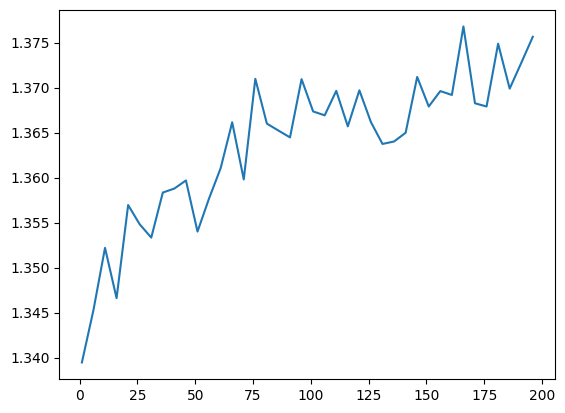

In [100]:
range_nlatents =  range(1,200, 5)
RMSE_nlatents = []
for nlatents in range_nlatents:
  print('Value of nlatents: ' + str(nlatents))
  algoLatent = SVD(n_factors = nlatents, biased = True)
  algoLatent.fit(trainset)
  predictions = algoLatent.test(testset)
  RMSE_nlatents.append(accuracy.rmse(predictions))

plt.figure()
plt.plot(range_nlatents, RMSE_nlatents)

The purpose of the previous plots is to check if the 'biased' parameter affects RMSE. We can observe that by setting the biased parameter to True we obtain lower ranges.

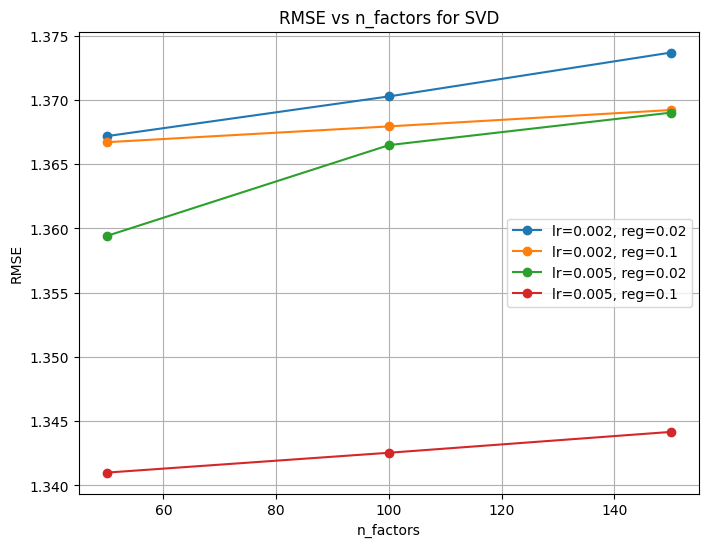

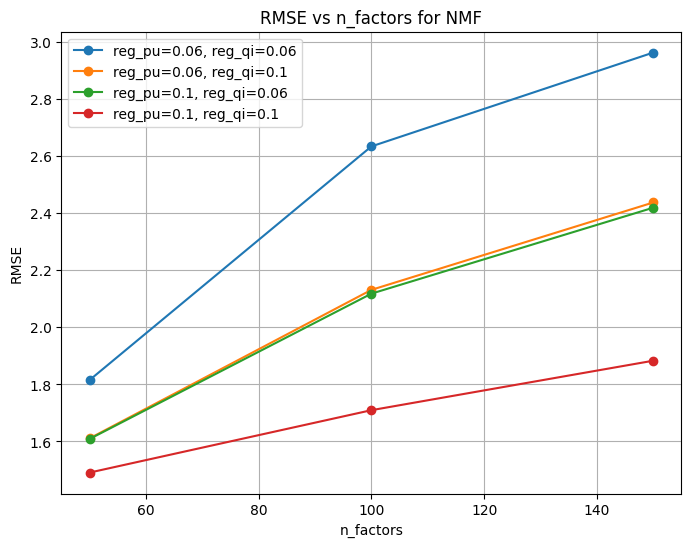

In [101]:
# Define models and corresponding grids
param_grids = {
    'SVD': {
        'n_factors': [50, 100, 150],
        'biased': [True],
        'lr_all': [0.002, 0.005],
        'reg_all': [0.02, 0.1]
    },
    'NMF': {
        'n_factors': [50, 100, 150],
        'reg_pu': [0.06, 0.1],
        'reg_qi': [0.06, 0.1]
    }
}

# Store results
results = []
best_models = {}  # To store the best model for each algorithm

# Loop through algorithms and perform grid search
for algo_name, param_grid in param_grids.items():
    algo_class = eval(algo_name)
    gs = GridSearchCV(algo_class, param_grid, measures=['rmse', 'mae'], cv=3, n_jobs=-1)
    gs.fit(data)  # Fit on the full dataset to find best parameters

    # Store the best model
    best_models[algo_name] = gs.best_estimator

    # Store the result of the grid search
    results.append({
        'Algorithm': algo_name,
        'Best RMSE': gs.best_score['rmse'],
        'Best MAE': gs.best_score['mae'],
        'Best Params': gs.best_params['rmse']
    })

    # Plotting the RMSE values for different hyperparameters
    if algo_name == 'SVD':
        # Extract parameters for plotting RMSE
        n_factors = param_grid['n_factors']
        lr_all = param_grid['lr_all']
        reg_all = param_grid['reg_all']

        # Plot RMSE across n_factors, lr_all, reg_all
        plt.figure(figsize=(8, 6))
        for lr in lr_all:
            for reg in reg_all:
                rmse_scores = []
                for nf in n_factors:
                    mask = [(params['n_factors'] == nf) and (params['lr_all'] == lr) and (params['reg_all'] == reg)
                            for params in gs.cv_results['params']]
                    rmse_scores.append([gs.cv_results['mean_test_rmse'][i] for i in range(len(gs.cv_results['params'])) if mask[i]][0])

                plt.plot(n_factors, rmse_scores, marker='o', label=f'lr={lr}, reg={reg}')

        plt.title('RMSE vs n_factors for SVD')
        plt.xlabel('n_factors')
        plt.ylabel('RMSE')
        plt.legend()
        plt.grid(True)
        plt.show()

    elif algo_name == 'NMF':
        # Extract parameters for plotting RMSE
        n_factors = param_grid['n_factors']
        reg_pu = param_grid['reg_pu']
        reg_qi = param_grid['reg_qi']

        # Plot RMSE across n_factors, reg_pu, reg_qi
        plt.figure(figsize=(8, 6))
        for rp in reg_pu:
            for rq in reg_qi:
                rmse_scores = []
                for nf in n_factors:
                    mask = [(params['n_factors'] == nf) and (params['reg_pu'] == rp) and (params['reg_qi'] == rq)
                            for params in gs.cv_results['params']]
                    rmse_scores.append([gs.cv_results['mean_test_rmse'][i] for i in range(len(gs.cv_results['params'])) if mask[i]][0])

                plt.plot(n_factors, rmse_scores, marker='o', label=f'reg_pu={rp}, reg_qi={rq}')

        plt.title('RMSE vs n_factors for NMF')
        plt.xlabel('n_factors')
        plt.ylabel('RMSE')
        plt.legend()
        plt.grid(True)
        plt.show()

In [102]:
# Show results of the grid search
results_df = pd.DataFrame(results)
results_df

Algorithm  Best RMSE  Best MAE  \
0       SVD   1.340999  1.008026   
1       NMF   1.490726  1.133014   

                                         Best Params  
0  {'n_factors': 50, 'biased': True, 'lr_all': 0....  
1    {'n_factors': 50, 'reg_pu': 0.1, 'reg_qi': 0.1}

In [103]:
for index, row in results_df.iterrows():
    print(f"Algorithm: {row['Algorithm']}")
    print(f"Best Params: {row['Best Params']}")
    print("-" * 20)

Algorithm: SVD
Best Params: {'n_factors': 50, 'biased': True, 'lr_all': 0.005, 'reg_all': 0.1}
--------------------
Algorithm: NMF
Best Params: {'n_factors': 50, 'reg_pu': 0.1, 'reg_qi': 0.1}
--------------------


In [104]:
# Choose the best algorithm based on the best RMSE from the grid search
best_algorithm_name = results_df.loc[results_df['Best RMSE'].idxmin()]['Algorithm']
best_model_latent = best_models[best_algorithm_name]
print(f"Using the best model: {best_algorithm_name} with parameters: {results_df.loc[results_df['Best RMSE'].idxmin()]['Best Params']}")

Using the best model: SVD with parameters: {'n_factors': 50, 'biased': True, 'lr_all': 0.005, 'reg_all': 0.1}


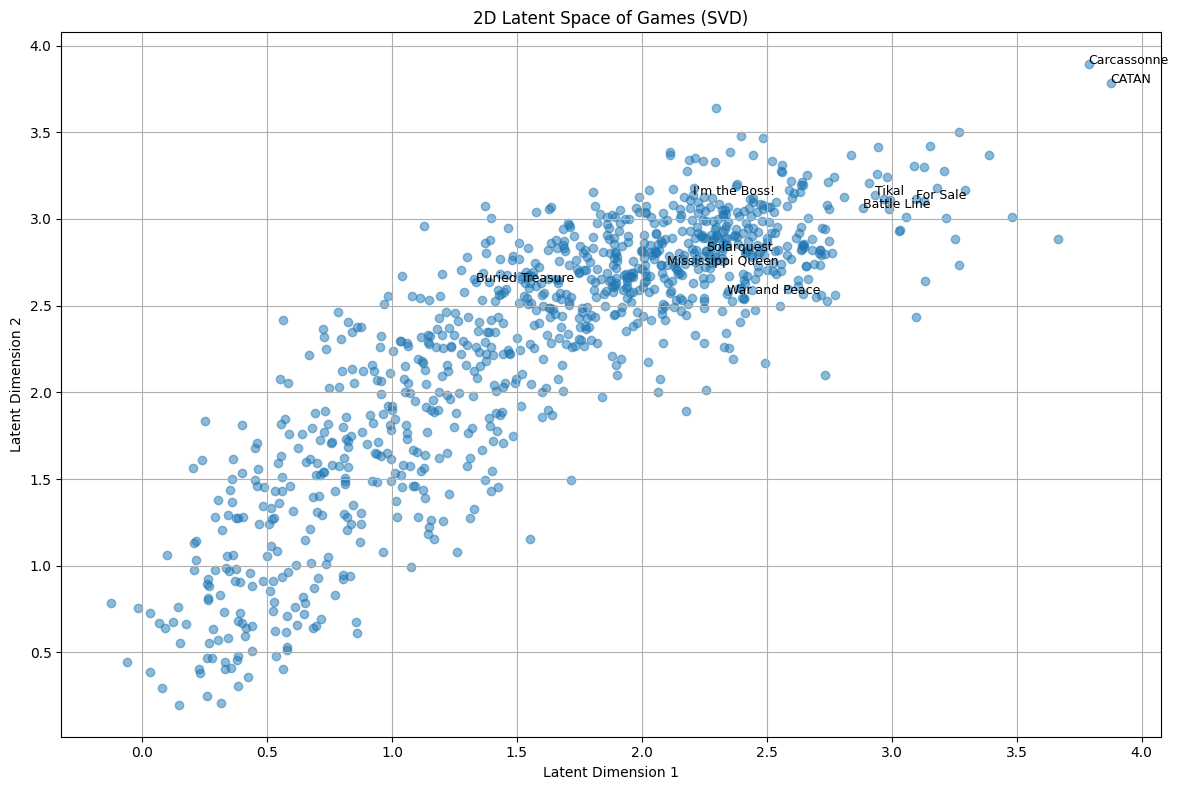

In [105]:
# Train SVD with 2D latent space
svd_2d = SVD(n_factors=2, lr_all=0.005, reg_all=0.1, biased = False)
svd_2d.fit(trainset)

# Get inner and raw item IDs
item_inner_ids = list(trainset.all_items())
item_raw_ids = [trainset.to_raw_iid(inner_id) for inner_id in item_inner_ids]

# Get game names for raw IDs
item_names = [games.loc[games['id'] == raw_id, 'name'].values[0] for raw_id in item_raw_ids]

# Extract 2D item latent factors
item_factors_2d = np.array([svd_2d.qi[inner_id] for inner_id in item_inner_ids])

# Plot
plt.figure(figsize=(12, 8))
plt.scatter(item_factors_2d[:, 0], item_factors_2d[:, 1], alpha=0.5)

# Label a sample of the points
for i, name in enumerate(item_names[:10]):  # Adjust number to control clutter
    plt.text(item_factors_2d[i, 0], item_factors_2d[i, 1], name, fontsize=9)

plt.title("2D Latent Space of Games (SVD)")
plt.xlabel("Latent Dimension 1")
plt.ylabel("Latent Dimension 2")
plt.grid(True)
plt.tight_layout()
plt.show()

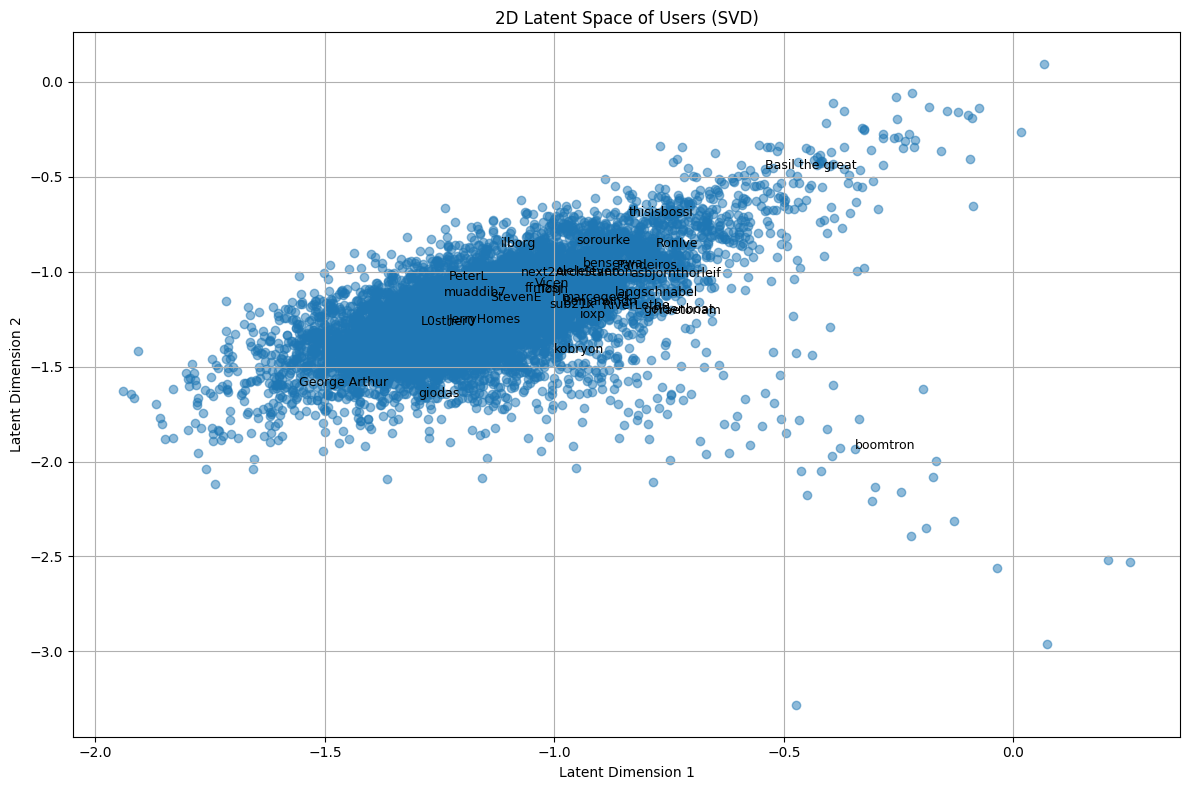

In [106]:
# Train SVD with 2D latent space
svd_2d = SVD(n_factors=2, lr_all=0.005, reg_all=0.1, biased = False)
svd_2d.fit(trainset)

# Get all inner user IDs
user_inner_ids = list(trainset.all_users())
user_raw_ids = [trainset.to_raw_uid(inner_id) for inner_id in user_inner_ids]

# Extract 2D user latent factors
user_factors_2d = np.array([svd_2d.pu[inner_id] for inner_id in user_inner_ids])

# Plot
plt.figure(figsize=(12, 8))
plt.scatter(user_factors_2d[:, 0], user_factors_2d[:, 1], alpha=0.5)

# Label a few users (e.g. first 30)
for i, user_id in enumerate(user_raw_ids[:30]):
    plt.text(user_factors_2d[i, 0], user_factors_2d[i, 1], user_id, fontsize=9)

plt.title("2D Latent Space of Users (SVD)")
plt.xlabel("Latent Dimension 1")
plt.ylabel("Latent Dimension 2")
plt.grid(True)
plt.tight_layout()
plt.show()

The users with more ratings are outliers

In [107]:
reviews[reviews['user'] == 'Cristofore']

Empty DataFrame
Columns: [Unnamed: 0, user, rating, comment, ID, name]
Index: []

In [108]:
best_model_latent = SVD(n_factors=50, lr_all=0.005, reg_all=0.1, biased = True)
best_model_latent.fit(trainset)

# Save SVD model
with open("svd_model.pkl", "wb") as f:
    pickle.dump(best_model_latent, f)

user = 'jbourgel'

# Games user has already rated
rated_game_ids = reviews[reviews["user"] == user]["ID"].unique()

# All possible game ids
all_game_ids = games["id"].unique()

# Filter out the ones already rated
unseen_game_ids = [gid for gid in all_game_ids if gid not in rated_game_ids]

# Predict ratings for the unseen games
predictions_user = [(gid, best_model_latent.predict(user, gid).est) for gid in unseen_game_ids]

# Sort by predicted rating
top_k = 10
top_predictions = sorted(predictions_user, key=lambda x: x[1], reverse=True)[:top_k]

# Get game info from the original games DataFrame
top_game_ids = [pred[0] for pred in top_predictions]
recommended_games = games[games["id"].isin(top_game_ids)][["id", "name", "rating"]]
print("\nTop Recommended Games:")
print(recommended_games.reset_index(drop=True))


Top Recommended Games:
     id                                   name   rating
0     1                             Die Macher  7.58777
1    77  EastFront: The War in Russia, 1941-45  7.67447
2    91                         Paths of Glory  8.07689
3    93                              El Grande  7.76343
4   188                                     Go  7.65578
5   234            Hannibal: Rome vs. Carthage  7.77953
6   243                  Advanced Squad Leader  8.00731
7   490                               Warangel  7.74555
8   586                               Up Front  7.89594
9  1447       1841: Railways in Northern Italy  7.91335


In [109]:
# Get predictions on test set
predictions = best_model_latent.test(testset)

# Calculate performance metrics
print("Evaluation Metrics:")
rmse = accuracy.rmse(predictions)
mae = accuracy.mae(predictions)

Evaluation Metrics:
RMSE: 1.3416
MAE:  1.0053


In [110]:
precision, recall = precision_recall_at_k(predictions, k=10)
print(f"Precision@10: {precision:.4f}")
print(f"Recall@10: {recall:.4f}")

Precision@10: 0.5861
Recall@10: 0.5651


Now we represent the projection of the latent space of the games created with the SVD model. Only the 30 first games will have the id label to ensure readability. The games that are close to each other have similar latent factors.

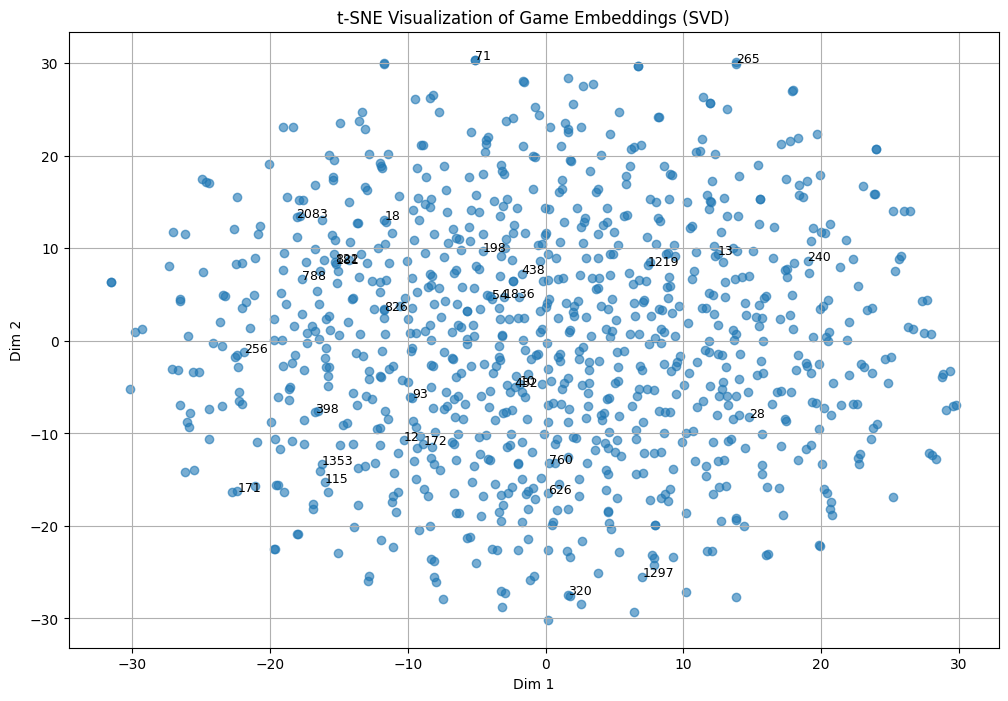

In [111]:
# Get game factors
item_ids = trainset.all_items()
item_inner_ids = list(item_ids)
item_raw_ids = [trainset.to_raw_iid(inner_id) for inner_id in item_inner_ids]
item_factors = np.array([best_model_latent.qi[inner_id] for inner_id in item_inner_ids])

# Reduce to 2D
tsne = TSNE(n_components=2, random_state=42, perplexity = 15)
item_2d = tsne.fit_transform(item_factors)

# Plot
plt.figure(figsize=(12, 8))
plt.scatter(item_2d[:, 0], item_2d[:, 1], alpha=0.6)
for i, item_id in enumerate(item_raw_ids[:30]):  # label a few
    plt.text(item_2d[i, 0], item_2d[i, 1], item_id, fontsize=9)
plt.title("t-SNE Visualization of Game Embeddings (SVD)")
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.grid(True)
plt.show()

The following plot represents the user-item matrix of 10 users and 10 games. We can see that the games with predicted low ratings will propagate over users and the same with high ratings.

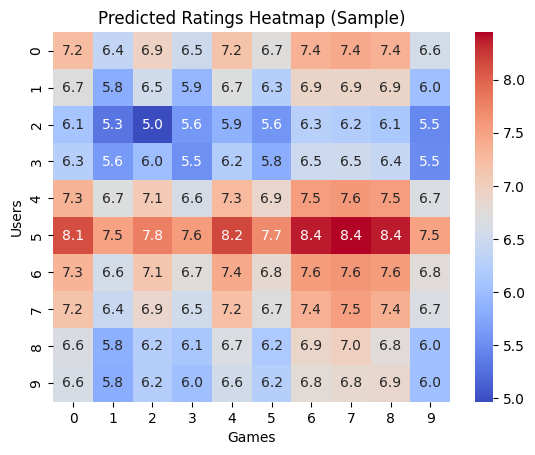

In [112]:
# Pick a sample of users and items

sample_users = list(trainset.all_users())[:10]
sample_items = list(trainset.all_items())[:10]

matrix = np.zeros((len(sample_users), len(sample_items)))
for i, uid in enumerate(sample_users):
    for j, iid in enumerate(sample_items):
        matrix[i, j] = best_model_latent.predict(trainset.to_raw_uid(uid), trainset.to_raw_iid(iid)).est

sns.heatmap(matrix, annot=True, fmt=".1f", cmap="coolwarm")
plt.xlabel("Games")
plt.ylabel("Users")
plt.title("Predicted Ratings Heatmap (Sample)")
plt.show()